# Predicting Hard Drive Failure (Daniela)

Hard Drive failure can have a negative impact, be it for a private persons loss of valuable memories or technical failure of mass storage companies. While individual persons mostly only rely on one individual hard drive and might not possess a back-up of their data, data storage facilities apply regular backup measures to prevent loss of data.  
However, hard drives are clustered into "storage pods" (servers that group 60 hard drives) and thus, "it is necessary [...] to anticipate such failures as a single failing hard drive could impede the whole storage pod’s operation." (Amram M., Dunn J., Toledano J. J. & Zhuo, Y. D. (2021). Interpretable predictive maintenance for hard drives. *Machine Learning with Applications 5 (2021) 100042*)

<br>
<br>

### The Data

For this project we are using the data from Blackblaze, a large data storage provider with roughly 200.000 hard drives. (11.03.2022)

All of the hard drives within their storage facility communications everyday a range of [S.M.A.R.T. (Self-Monitoring, Analysis and Reporting Technology)](https://en.wikipedia.org/wiki/S.M.A.R.T.) features, which have the main function to report indicators about the drive reliability with the intent of identifying imminent hard drive failure.  

Some examples of SMART features that are marked as important are:
* 05 - Reallocated Sectors Count
* 10 - Spin Retry Count
* 184 - End-to-End error / IOEDC
* 187 - Reported Uncorrectable Errors
* 188 - Command Timeout

During the EDA we look further into the SMART features that are most important and will provide further information about the features, which are playing an important role in our analysis.

The amount of SMART features, as well which SMART features are communicated differes from year to year (can also differ from Quarter to Quarter), as well as from hard drive to hard drive. Also different brands might communicate different values for the same feature, making a overall comparison challenging.

In addition, the date, serial_number, model, capacity_bytes as well as the failure column are added to the data, where failure is either a 0 (no failure) or 1 (failure).

As the amount of data is quiet large, a Google Cloud SQL Instance is used to save the data temporarily and only relevant parts are queried when needed. However, even with this the decision was made to focus only on a specific time period for this project. Thus, we only take data from 2019 to 2021 into consideration.

The data can be found [here](https://www.backblaze.com/b2/hard-drive-test-data.html).

As the Google Cloud Instance is only temporarily available we also shortly explain what data we used for which part of our project, so that a replication is possible, when having the data obtained.

<br>
<br>

## EDA, Data Processing and Baseline Model

We start by loading the necessary libraries for the EDA as well as loading the data for the first quarter of 2021 and start getting some basic insights.

The first quarter will be loaded directly from the CSV files. This way we can start our first EDA on the overall dataset and get some insights and make the decision in which direction we want to move.

However, we still directly establish the connection to our data base in the beginning, so that we are able to query and data from 2019 to 2021 when needed.

In [2]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import os

from tqdm import tqdm  
from time import sleep 
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sklearn.feature_selection import mutual_info_classif

import warnings
warnings.filterwarnings('ignore')

plt.style.use('classic')

RSEED = 42

In [5]:
# access the database
load_dotenv()

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

In [6]:
conn = psycopg2.connect(
    database=DATABASE,
    user=USER_DB,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

In [7]:
# creating the query and loading some test data into a pandas data frame
query_string = 'SELECT * FROM public."2021" LIMIT 10'
df = pd.read_sql(query_string, conn)
df.head(2)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2020-09-18,40P0A05UF97G,TOSHIBA MG07ACA14TA,14000519643136,0,100,0,100.0,0.0,100,...,None,None,None,None,None,None,None,None,None,None
1,2020-09-18,88P0A0BZF97G,TOSHIBA MG07ACA14TA,14000519643136,0,100,0,100.0,0.0,100,...,None,None,None,None,None,None,None,None,None,None


## Getting data and some insights

Due to the size of the data set we focus on one quarter and take the first quarter of 2021 as a starting point for our EDA.

The data for the first quarter was combined in a CSV file (the code to load the individual files is commented out, but can be re-run if needed) and for convenience we load the data directly from the combined data frame for Q1.

Alternatively, we also have the possibility to query that data directly from the SQL database using the established connection.

In [ ]:
# # concatenate the files per day on quarter basis and input the date column as date format
# for i in range(1, 5):
#     path = rf'../data/raw/data_Q{i}_2021'
#     all_files = glob.glob(os.path.join(path, "*.csv"))

#     df_from_each_file = (pd.read_csv(f,parse_dates=["date"]) for f in all_files)
#     concatenated_df = pd.concat(df_from_each_file, ignore_index=True)

#     concatenated_df.to_csv(f'../data/interim/data_q{i}.csv', index=False)

In [3]:
# load the q1 data set from CSV file
q1 = pd.read_csv('../data/interim/data_q1.csv', parse_dates=['date'])

In [9]:
# display the first couple of entries
display(q1.head(2))
display(q1.tail(2))
print(q1.shape)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
0,2021-03-25,ZHZ65F2W,ST12000NM0008,12000138625024,0,82.0,162621344.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-25,ZLW0EGC7,ST12000NM001G,12000138625024,0,72.0,14988480.0,NaN,NaN,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
15287370,2021-03-28,ZA13ZBCT,ST8000DM002,8001563222016,0,77.0,49613768.0,NaN,NaN,86.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15287371,2021-03-28,X0GEV9EC,WDC WUH721414ALE6L4,14000519643136,0,100.0,0.0,138.0,95.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(15287372, 149)


Our Q1 2021 data consists of ~15.000.000 entries with 149 features. Out of these 144 are SMART features, which are statistics communicated directly by the hard drive.

After loading the data set and inspecting the first/last observations within the data frame, we shortly look into the alternative columns we have available and also inspect our potential target variable 'failure').

Date: Timestamp added from Blackblaze for the individual days
Serial_Number: Unique identifier per hard drive
Model: the model of the hard drive
Capacity_bytes: the storage capacity per hard drive
Failure: 0 (no failure) or 1 (failure)

In [10]:
# Look at the amount of hard drives reported
q1.query('date == "2021-03-31"')['serial_number'].nunique()

175443

As mentioned we have for each hard drive in use one observation per day. Thus, at the end of march 2021 roughly 175.000 hard drives are reported per day.

As we have many healthy observations, but likely not that many failures, next we need to understand if we are dealing with a balanced or unbalanced dataset.

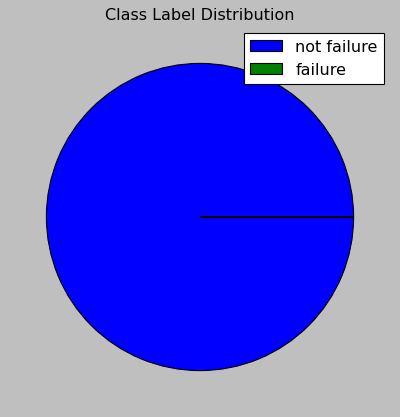

In [11]:
plt.pie(q1.failure.value_counts())
plt.legend(['not failure', 'failure'])
plt.title('Class Label Distribution');

From this plot it is already quiet clear that we are dealing with a strongly imbalanced data set. As there are multiple ways to approach this, we decided further down the road which approach is reasonable, after we gained some initial insight after the first EDA.

Before we move to the target variable, we are looking at some basic descriptive statistics, data types and potential of missing data.

In [5]:
# create a data frame with all descriptive statistics for the Q1 data set
descriptive_stats = q1.describe().T

# query the data frame for columns which do not have entries    
descriptive_stats.query('count == 0')

,count,mean,std,min,25%,50%,75%,max
smart_15_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_15_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_250_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_250_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_251_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_251_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_252_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_252_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_255_normalized,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smart_255_raw,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With this we already see that some smart features do not contain any information at all and we can drop them directly to reduce the amount of features within the data set.

In [6]:
columns_to_drop = descriptive_stats.query('count == 0').reset_index()['index'].to_list()
q1.drop(columns_to_drop, axis=1, inplace=True)
q1.shape

(15287372, 139)

In [7]:
q1.groupby('model').count()

,date,serial_number,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,smart_3_raw,...,smart_242_normalized,smart_242_raw,smart_245_normalized,smart_245_raw,smart_247_normalized,smart_247_raw,smart_248_normalized,smart_248_raw,smart_254_normalized,smart_254_raw
model,,,,,,,,,,,,,,,,,,,,,
DELLBOSS VD,10842,10842,10842,10842,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HGST HDS5C4040ALE630,2314,2314,2314,2314,2314,2314,2314,2314,2314,2314,...,0,0,0,0,0,0,0,0,0,0
HGST HMS5C4040ALE640,281692,281692,281692,281692,281631,281631,281631,281631,281631,281631,...,0,0,0,0,0,0,0,0,0,0
HGST HMS5C4040BLE640,1146496,1146496,1146496,1146496,1146387,1146387,1146387,1146387,1146387,1146387,...,0,0,0,0,0,0,0,0,0,0
HGST HMS5C4040BLE641,90,90,90,90,90,90,90,90,90,90,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WDC WD5000LPCX,4767,4767,4767,4767,4767,4767,0,0,4767,4767,...,0,0,0,0,0,0,0,0,0,0
WDC WD5000LPVX,17724,17724,17724,17724,17724,17724,0,0,17724,17724,...,0,0,0,0,0,0,0,0,0,0
WDC WD60EFRX,270,270,270,270,270,270,0,0,270,270,...,0,0,0,0,0,0,0,0,0,0



As a next step, we check the different hard drive models that we have in the data set ('model') to understand how the different types are represented and if there are different possibilities of failure per model.

In [30]:
# create a list based on the sorted model frequency (highest to lowest) to use for plotting
model_frequency = q1.model.value_counts().reset_index().iloc[:,0].to_list()

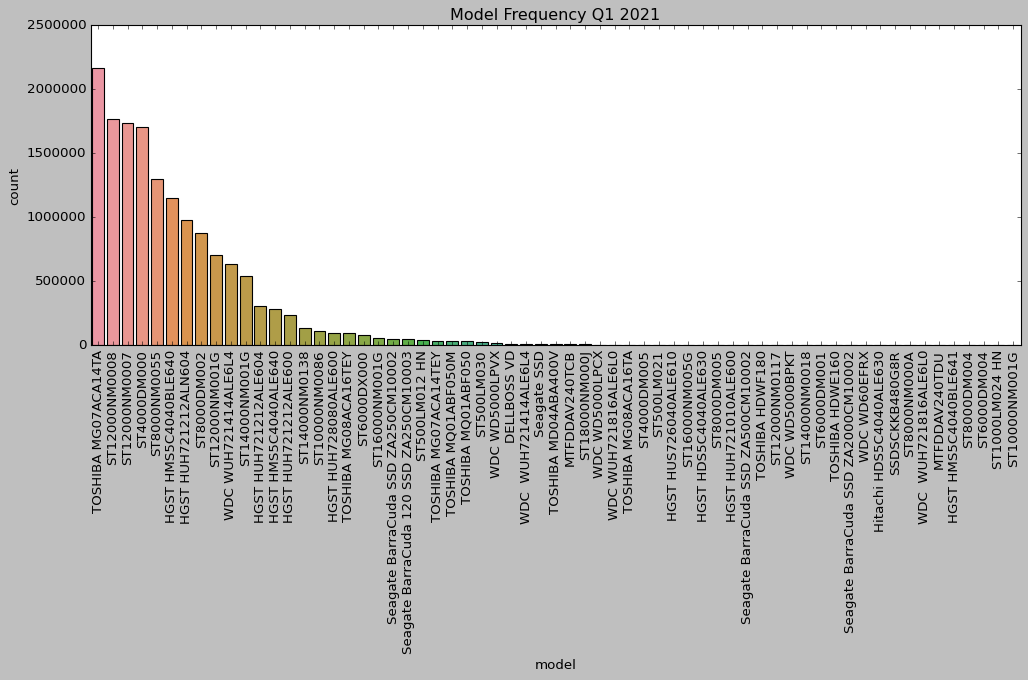

In [31]:
# look at the distribution of the different hdd models
plt.figure(figsize=(15, 5))
g = sns.countplot(q1.model, order=model_frequency)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Model Frequency Q1 2021');

As we have many different models and the graphic is getting a bit crowded, we look again at the Top 15 of the hard drives and will also focus on the Top 15 to look into the failure rate.

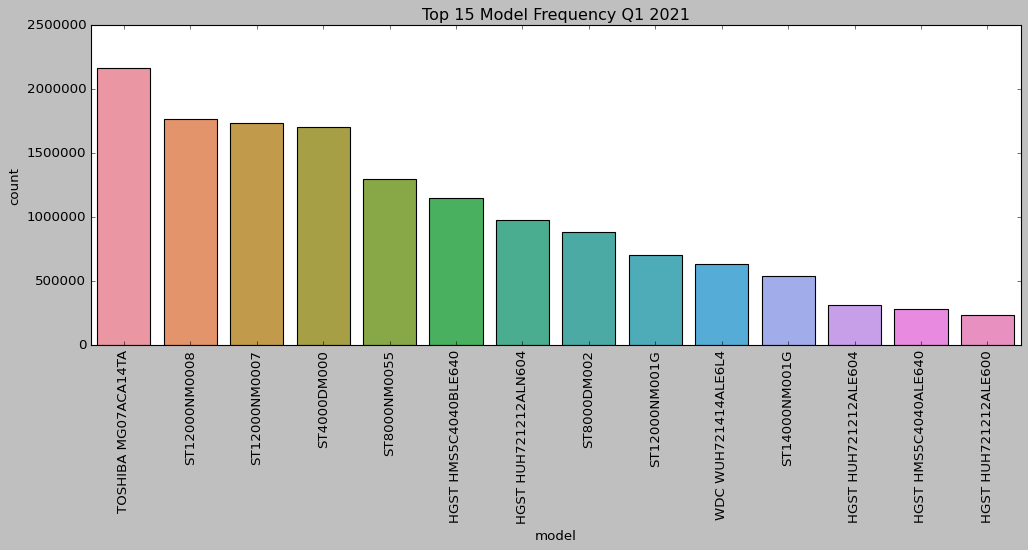

In [35]:
# look at the distribution of the different hdd models
plt.figure(figsize=(15, 5))
g = sns.countplot(q1.model, order=model_frequency[0:14])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 15 Model Frequency Q1 2021');

In [37]:
# create a separate data frame with only failed data
failure_q1 = q1.query('failure == 1')

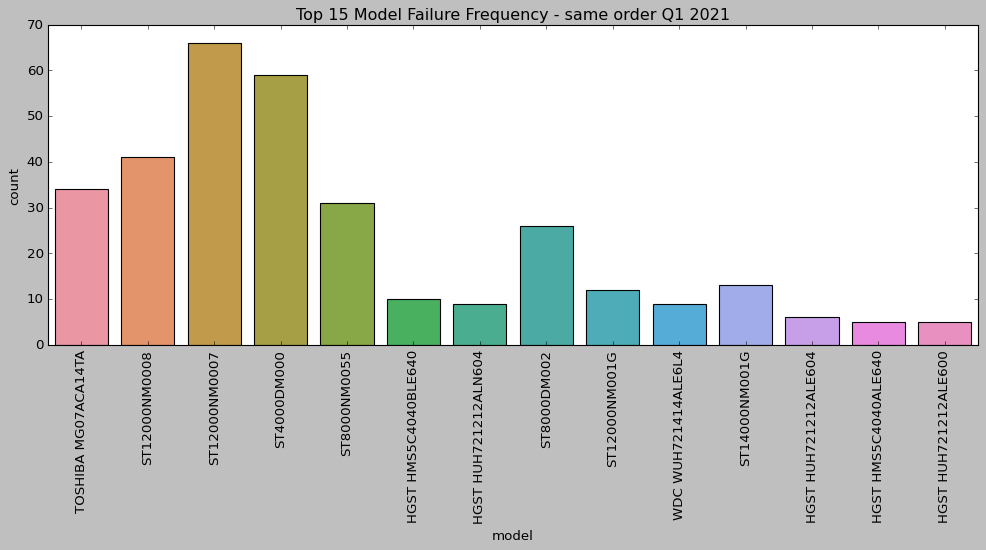

In [40]:
# plot the failure frequency per model in the same order as previous plot
plt.figure(figsize=(15, 5))
g = sns.countplot(failure_q1.model, order=model_frequency[0:14])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 15 Model Failure Frequency - same order Q1 2021');

We see that the higher represented models also have more total failures. For the last plot we kept the original Top 15 order, but next we order the plot again based on the highest total failure number per model.

In [42]:
# create a new column order list based on failure frequency / ignores models without any failure in Q1
failure_frequency = failure_q1.model.value_counts().reset_index().iloc[:,0].to_list()

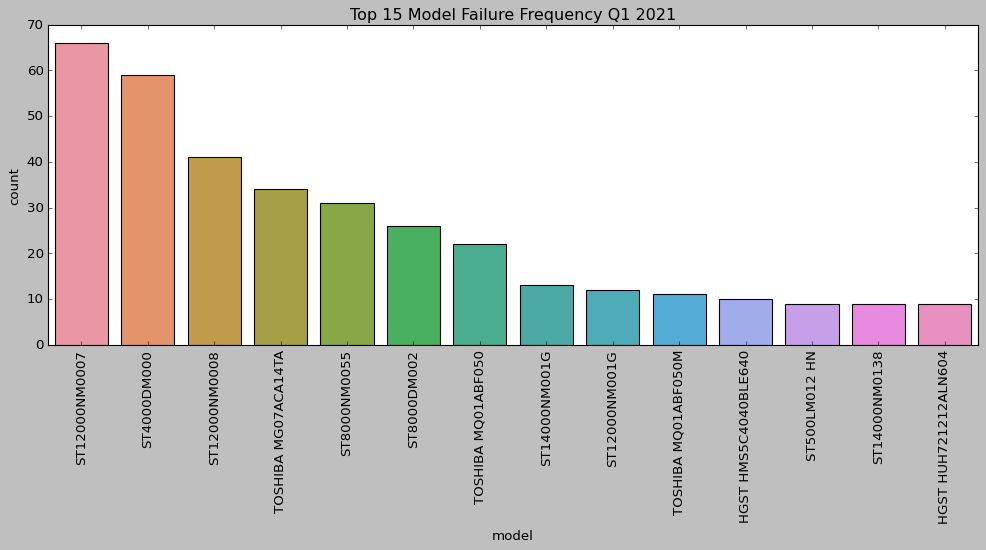

['ST12000NM0007',
 'ST4000DM000',
 'ST12000NM0008',
 'TOSHIBA MG07ACA14TA',
 'ST8000NM0055']

In [46]:
# plot failure frequency bt model type descending
plt.figure(figsize=(15, 5))
g = sns.countplot(failure_q1.model, order=failure_frequency[:14])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 15 Model Failure Frequency Q1 2021');
plt.show()

# print the Top 5 failure list
failure_frequency[:5]

For the Q1 data set, the ST1200NM0007 has the highest total amount of failures, closely follow by the ST4000DM000.

However, as this might not indicate a higher percentage failure, we look into the percentage distribution of the failures per hard drive next.

In [47]:
most_failure = q1.query('model == "ST12000NM0007" or model == "ST4000DM000" or model == "ST12000NM0008" or model == "TOSHIBA MG07ACA14TA" or model == "ST8000NM0055"')

In [52]:
# create a crosstab for the index=country with the proporatons 
cross_tab_prop_failure = pd.crosstab(index=most_failure['model'],
                             columns=most_failure['failure'],
                             normalize="index")

# create a crosstab for the index=country on total values
cross_tab_failure = pd.crosstab(index=most_failure['model'],
                        columns=most_failure['failure'])

cross_tab_prop_failure.reset_index(inplace=True)
cross_tab_prop_failure.sort_values(1, ascending=False, inplace=True)

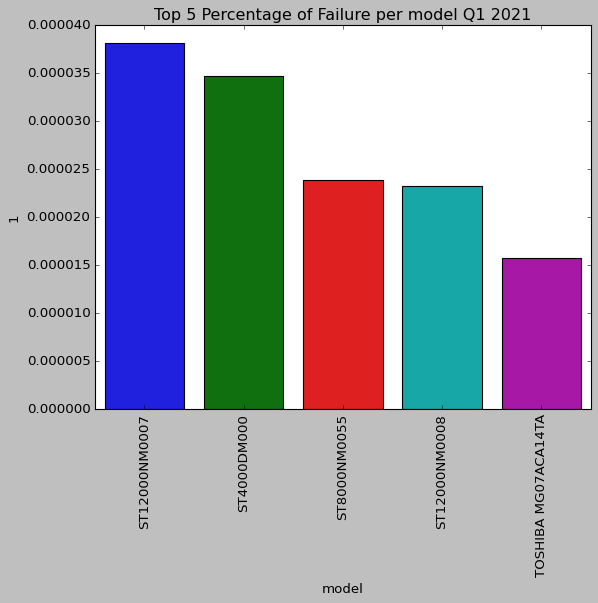

In [53]:
g = sns.barplot(data=cross_tab_prop_failure, x='model', y=1)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title('Top 5 Percentage of Failure per model Q1 2021');

While the percentage itself is not high, the ST12000NM0007 has the highest failure rate for Q1 2021. Next, we verify if we can confirm this for the whole data set we have set up in the SQL instance or if this might only be a trend for Q1 2021.

In [55]:
highest_failure_total = pd.read_sql("""
        SELECT model, COUNT(model), failure
        FROM public."2021" 
        GROUP BY model, failure
        HAVING failure = '1'
        ORDER BY count DESC
        """, conn)

highest_failure_total.iloc[:5,]

,model,count,failure
0,ST4000DM000,610,1
1,ST12000NM0007,494,1
2,ST8000NM0055,392,1
3,ST12000NM0008,366,1
4,TOSHIBA MG07ACA14TA,347,1


As already stated, the hard drive models communicate different SMART features based on model/brand and even if the similar features are communicated, the values differ based on model.

Thus, we are focusing only on one hard drive model and while the ST12000NM0007, the ST4000DM000 has actually a higher value of failures within our data set.  
As we are going to use only the hard drive data for drives that will eventually fail, we are selecting the ST4000DM000 as our data set and focus on this hard drive for the next step.

<br>
<br>
<br>
<br>
<br>
<br>



### ST4000DM000 - Data Processing and EDA

After having decided on a specific hard drive modelwe start by loading the full failure data set and a random sample of hard drives which have not been 

In [19]:
# load the test_model data for failures and success into specific data frames
test_model_failure = pd.read_csv('../data/special_purpose/ST4000DM000_failure.csv', parse_dates=['date'])
test_model_history = pd.read_csv('../data/special_purpose/ST4000DM000_history.csv', parse_dates=['date'])

# choose a random sample of the test_model_history to look into the correlation of features
test_model_success = test_model_history.query('failure == 0').sample(1000)

# concat the two separate data frames into one data frame
test_model_total = pd.concat([test_model_failure, test_model_success], axis=0)
test_model_total.reset_index(inplace=True)

test_model_total.drop('index', axis=1, inplace=True)
test_model_total.shape

(1610, 179)

In [20]:
# create a data frame for the overviw about the isnull values and a series containing the total count of the data frame
isnull = test_model_total.isnull().sum().reset_index(name='isnull')
total = pd.Series([test_model_total.shape[0] for _ in range(len(isnull))])

# create a dictionary and concat the the data to the data frame
data = {'isnull': isnull, 
        'total': total}

isnull = pd.concat(data, axis=1, ignore_index=True)

# give meaningful column names
isnull.columns = ['columns', 'isnull', 'total']

# add extra column containing the percentage of missing data per column
isnull['percentage_of_missing'] = isnull['isnull'] / isnull['total'] * 100

# create a list containing the column names which have more than specified percentage of missing values
drop_columns = isnull.query('percentage_of_missing > 40')['columns'].to_list()

# drop the columns with too much missing values from the data frame
test_model_total.drop(drop_columns, axis=1, inplace=True)

test_model_total.shape

(1610, 53)

In [21]:
# drop 5 rows which do not contain any smart data
test_model_total.dropna(how='any', inplace=True)
test_model_total.shape

(1609, 53)

#### Correlation Matrix

In [22]:
# check columns which only contain 0 values and drop them from the data frame
drop_columns = test_model_total.describe().T.query('mean == 0').reset_index()['index'].to_list()
test_model_total.drop(drop_columns, axis=1, inplace=True)

In [23]:
# construct correlation matrix
corr_mat = test_model_total.corr()

# drop columns which have no correlation at all
drop_columns = corr_mat[corr_mat['failure'].isnull()].reset_index()['index'].to_list()
test_model_total.drop(drop_columns, axis=1, inplace=True)

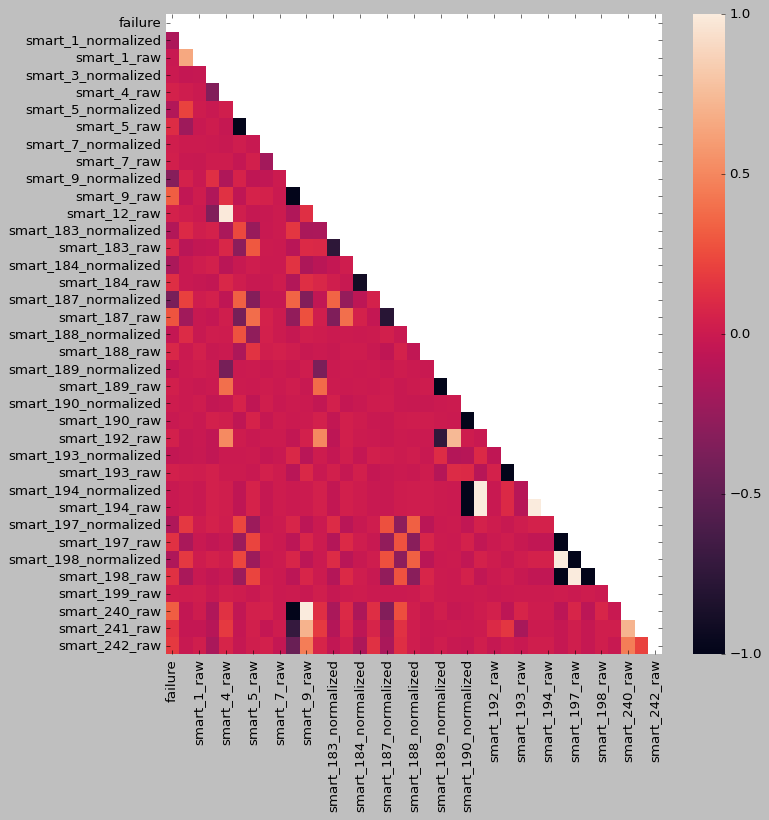

In [24]:
# create correlation matrix over all features
corr_mat = test_model_total.corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix)

In [25]:
# reset the index of the correlation matrix for further analysis (to find the features with the strongest correlation with failure)
corr_mat.reset_index(inplace=True)

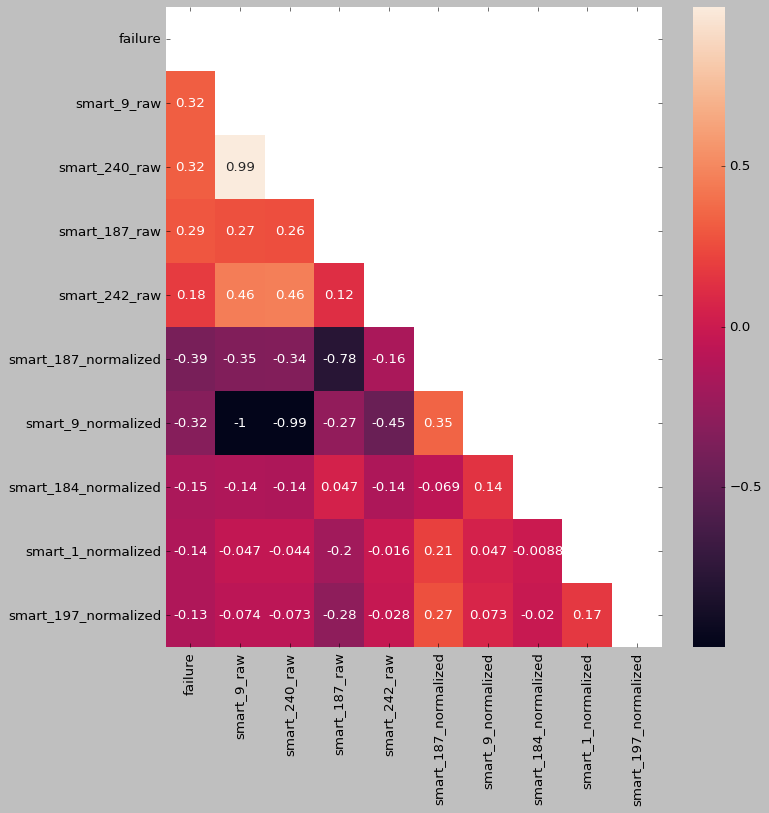

In [26]:
# reduce the correlation features to the most important ones
correlation_features = []

# identify the features with the highest positive correlation
for element in corr_mat.nlargest(5,'failure')['index']:
    correlation_features.append(element)

# identify the features with the highest negative correlation
for element in corr_mat.nsmallest(5,'failure')['index']:
    correlation_features.append(element)

# create correlation matrix over the top 10 features
corr_mat = test_model_total[correlation_features].corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix, annot=True)

#### Mutual Info

Split the data into X and y variables to check the mutual dependency of the different features in regards to the target variable

In [27]:
# split the data into X and y / focus on the most important features
X = test_model_total[correlation_features].drop('failure', axis=1)
y = test_model_total.failure

# create the mutual info classifier
mutual_info = mutual_info_classif(X, y)

# create a column list of the features used
columns = X.columns.to_list()

# concat the column names and the result from mutual_info
evaluation = pd.concat({"columns":pd.Series(columns),
                        'mutual_info': pd.Series(mutual_info)},
                         axis=1, ignore_index=True
)

evaluation.columns = ['feature', 'mutual_info']

display(evaluation.sort_values('mutual_info', ascending=False))

,feature,mutual_info
2,smart_187_raw,0.079505
4,smart_187_normalized,0.074550
1,smart_240_raw,0.074542
0,smart_9_raw,0.070555
5,smart_9_normalized,0.065844
8,smart_197_normalized,0.042671
3,smart_242_raw,0.037275
6,smart_184_normalized,0.023016
7,smart_1_normalized,0.022042


## Features

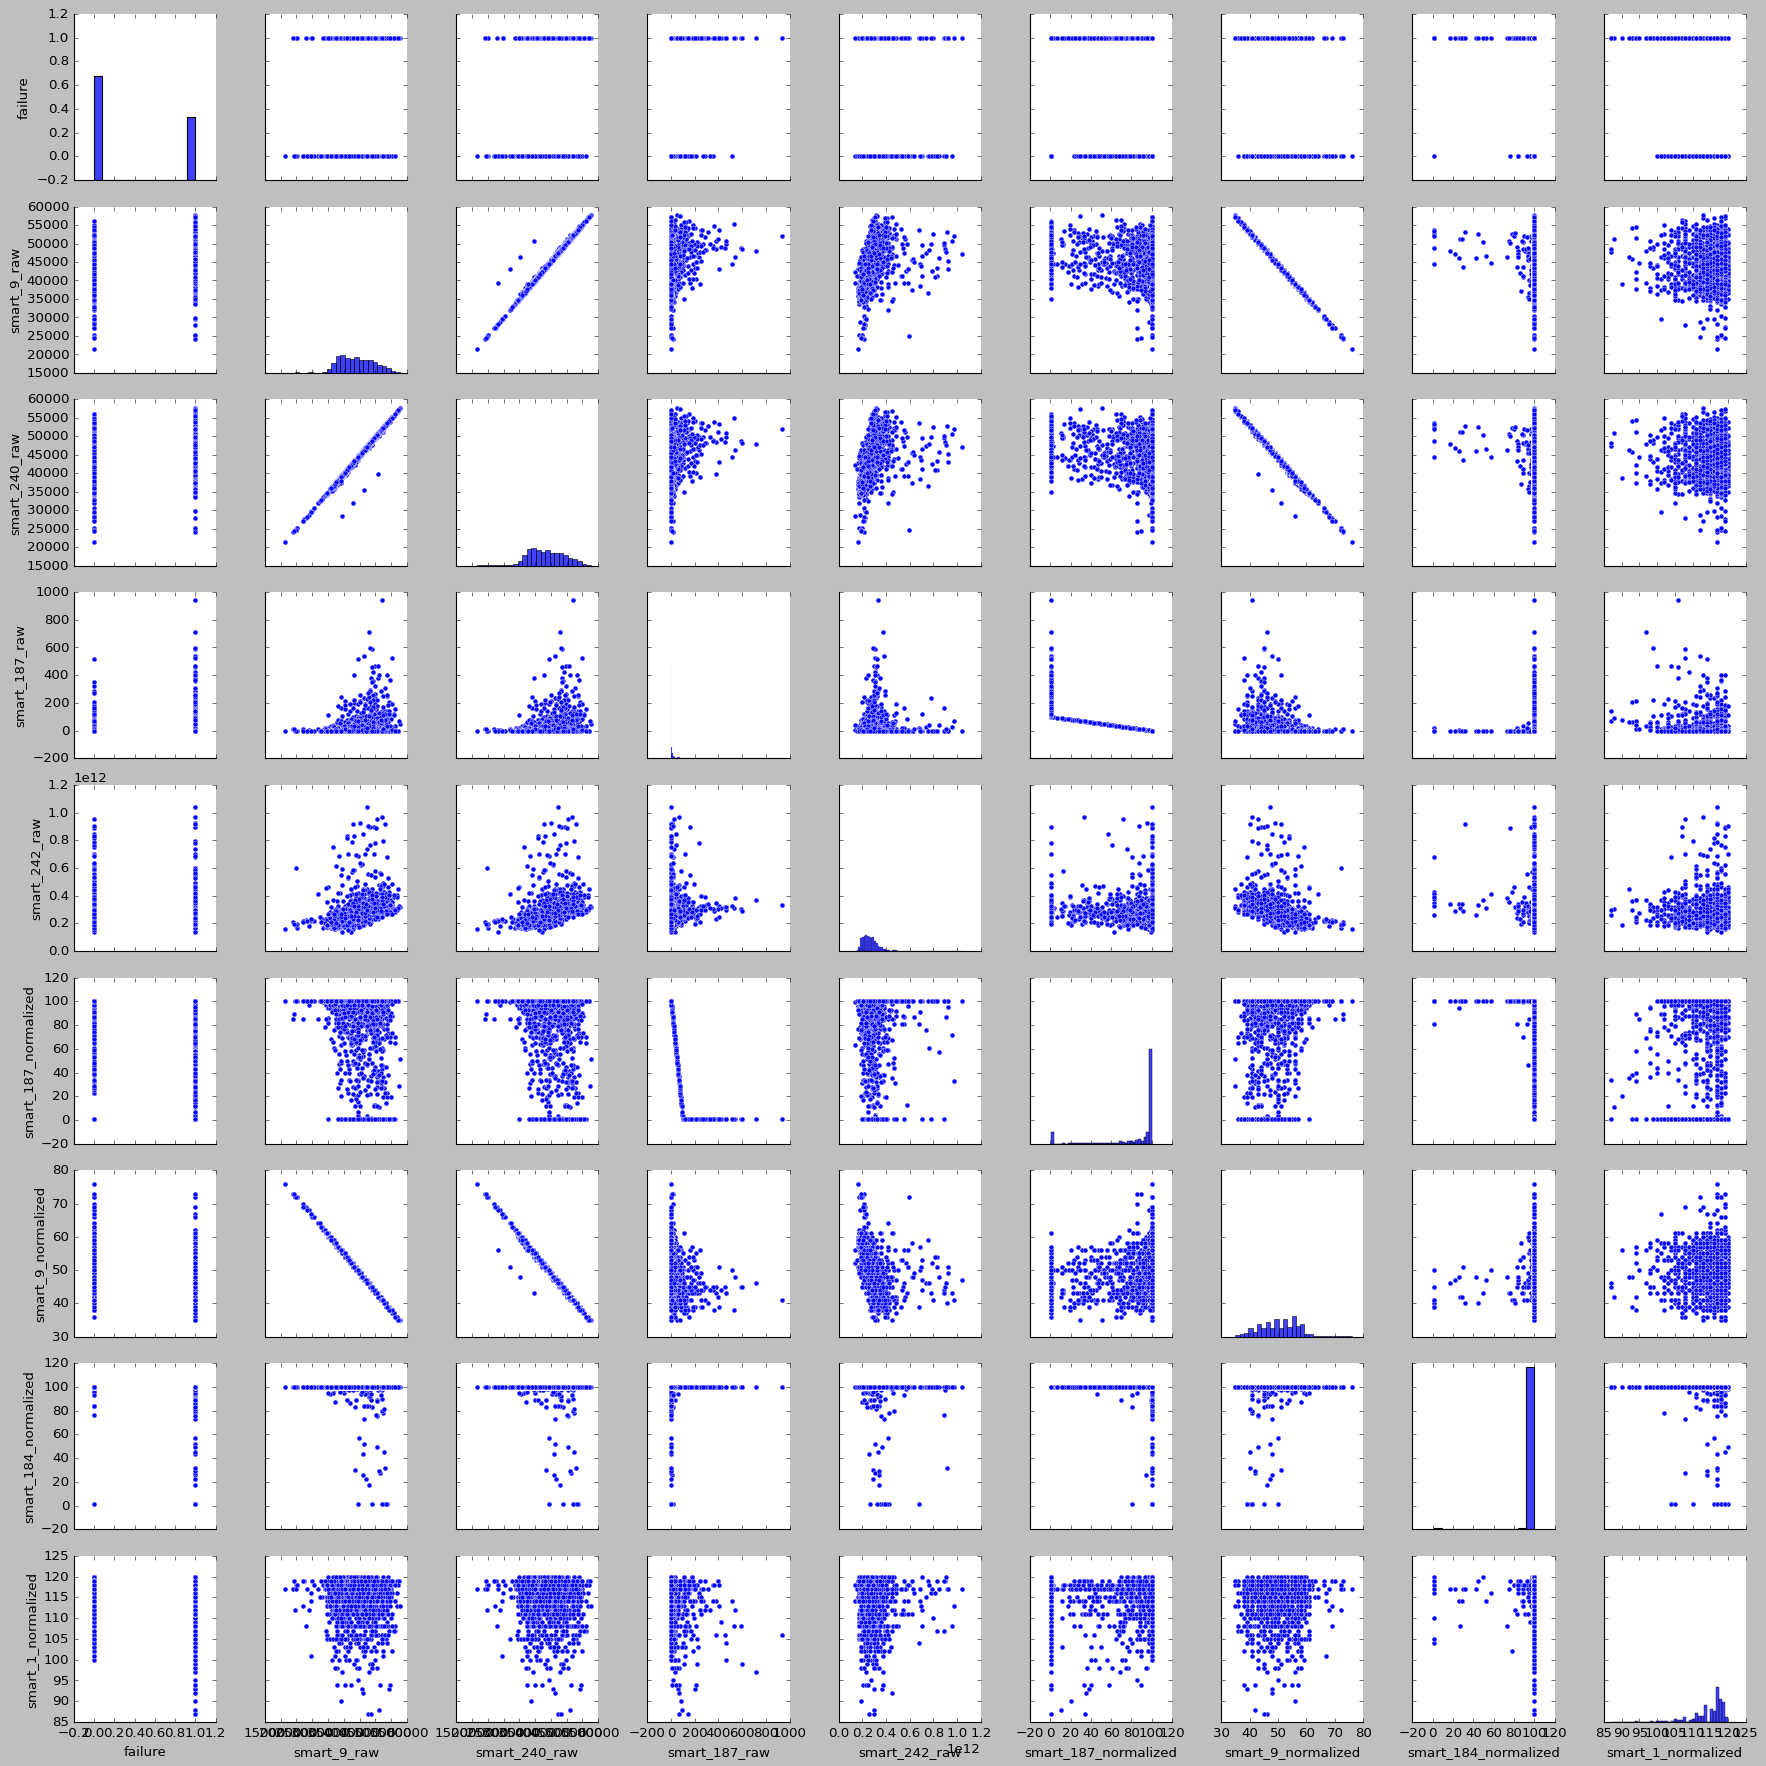

In [28]:
pairplot = test_model_total[correlation_features].reset_index()
sns.pairplot(pairplot.iloc[: ,1:-1]); 

In [29]:
all_columns = test_model_total.columns.to_list()

raw = []
norm = []

for element in all_columns:
    if 'raw' in element:
        raw.append(element)
    elif 'normalized' in element:
        norm.append(element)
    else:
        continue

raw_columns = []
norm_columns = []

for i in range(1, 255):
    if f'smart_{i}_raw'in raw and f'smart_{i}_normalized' in norm:
        raw_columns.append(f'smart_{i}_raw')
        norm_columns.append(f'smart_{i}_normalized')

feature = []

for element in raw_columns:
    feature.append(element.split('_')[1])

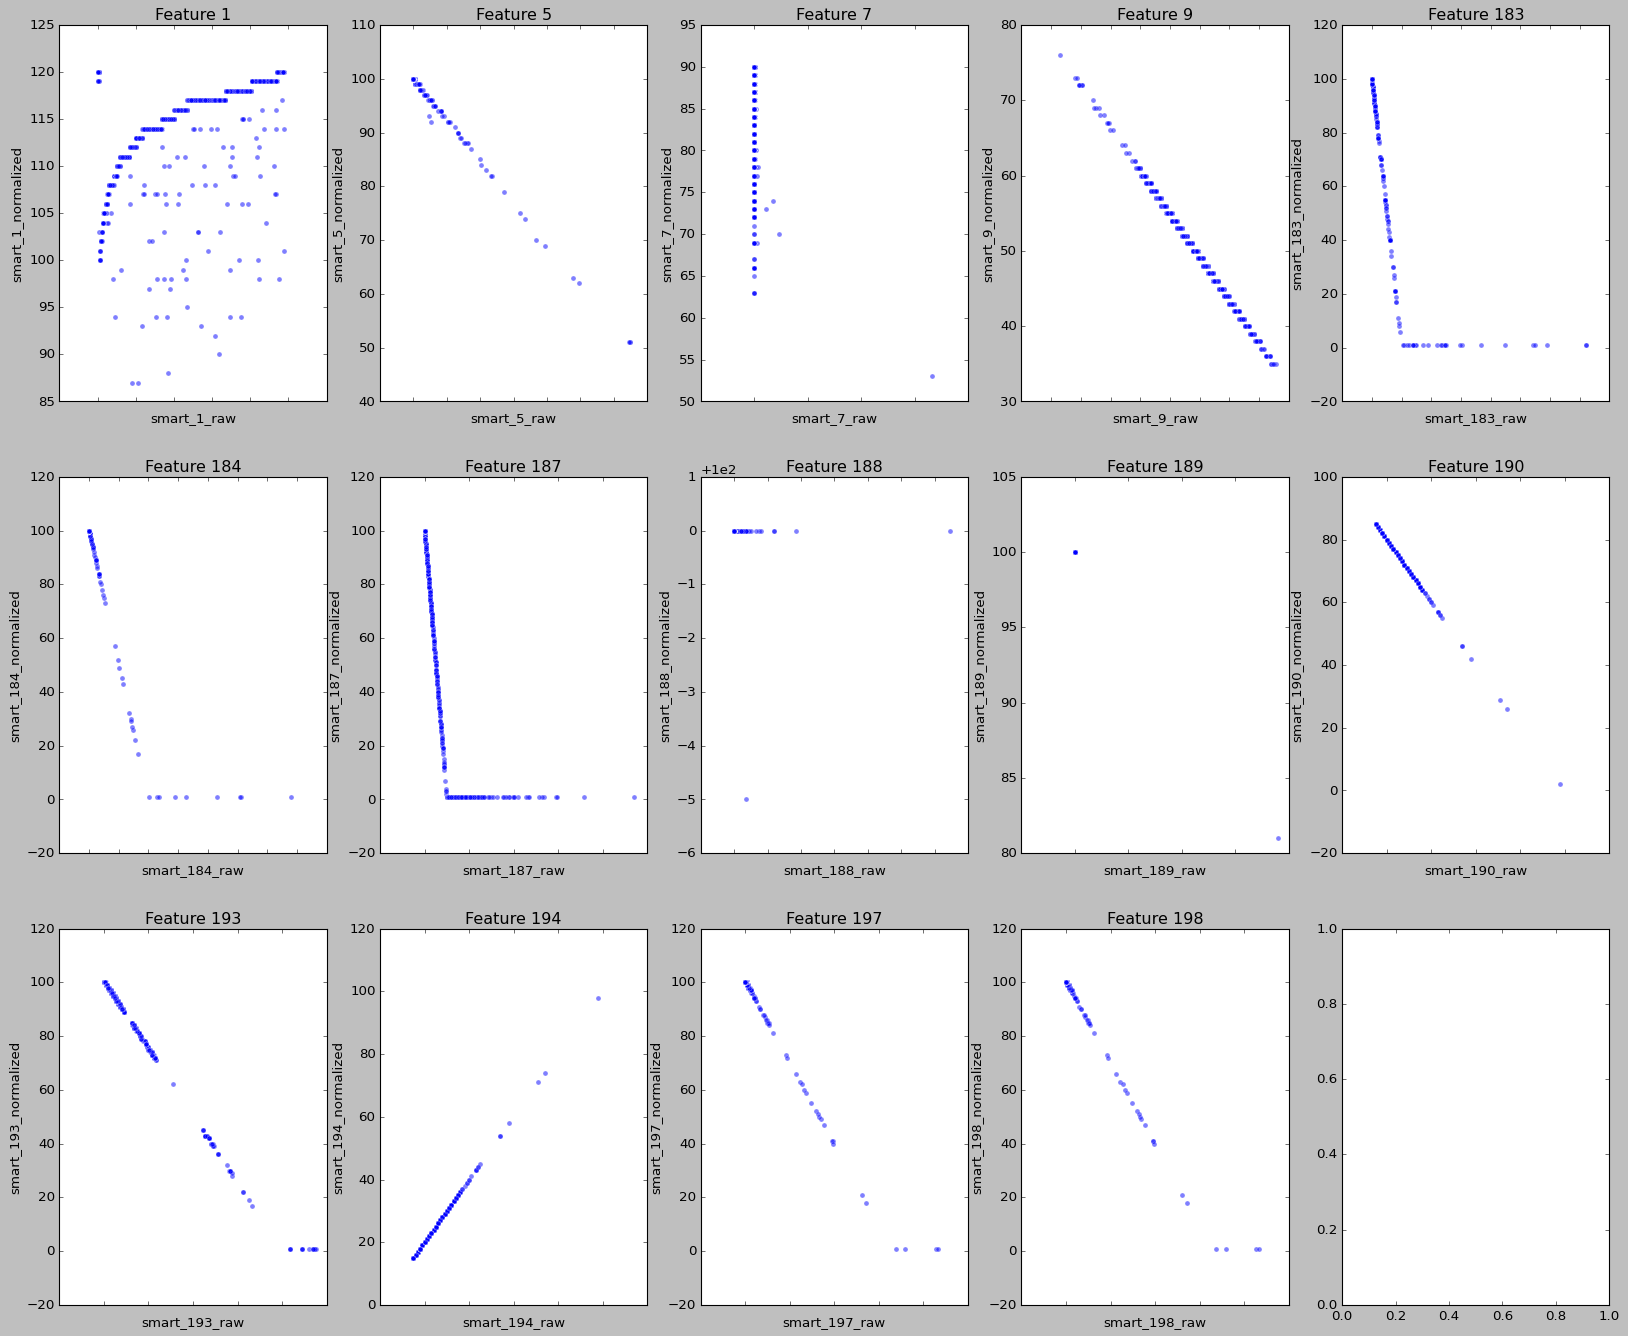

In [30]:
fig, ax = plt.subplots(3, 5, figsize=(25, 20))
counter = 0

for ind, val in enumerate(feature):
    sns.scatterplot(x=test_model_total[f'smart_{val}_raw'], y=test_model_total[f'smart_{val}_normalized'], ax=ax[counter, ind % 5], alpha=0.5)
    ax[counter, ind % 5].set_title(f'Feature {val}')
    ax[counter, ind % 5].set_xticklabels(ax[counter, ind % 5].get_xticklabels(), rotation=90)
    if ind == 4 or ind == 9 or ind == 14:
        counter += 1;

### load the main data set

In [31]:
# load the whole failure history data for one specific model (full history)
test_model_history = pd.read_csv('../data/special_purpose/ST4000DM000_history.csv', parse_dates=['date'])
test_model_history.shape

(241971, 179)

In [32]:
test_model_failure = pd.read_csv('../data/special_purpose/ST4000DM000_failure.csv', parse_dates=['date'])
test_model_failure.sort_values('date', inplace=True)

# drop one duplicate entry in the failure data frame (likely was repaired after failing the first time)
display(test_model_failure[test_model_failure.duplicated('serial_number')])
test_model_failure.drop_duplicates(keep='first', subset=None, inplace=True)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_normalized,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw
12,2021-10-11,Z302SQFX,ST4000DM000,4000787030016,1,111,32839264,NaN,NaN,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,2021-10-19,Z303VDR4,ST4000DM000,4000787030016,1,114,72410480,NaN,NaN,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create function for countdown target

In [33]:
# create a date_failure column
test_model_history['date_failure'] = test_model_history['serial_number'].map(test_model_failure.set_index('serial_number')['date'])

In [34]:
test_model_history.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,smart_2_raw,smart_3_normalized,...,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw,date_failure
0,2020-09-15,Z304KBK4,ST4000DM000,4000787030016,0,113.0,53991680.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-12-16
1,2020-09-15,Z304JGH0,ST4000DM000,4000787030016,0,111.0,31142392.0,NaN,NaN,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-14
2,2020-09-15,Z302SYHL,ST4000DM000,4000787030016,0,120.0,238681648.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-22
3,2020-09-15,S3010L7K,ST4000DM000,4000787030016,0,118.0,180888736.0,NaN,NaN,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-12-11
4,2020-09-15,Z304JM6A,ST4000DM000,4000787030016,0,114.0,59625576.0,NaN,NaN,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-24


In [35]:
# create a data frame for the overview about the isnull values and a series containing the total count of the data frame
isnull = test_model_history.isnull().sum().reset_index(name='isnull')
total = pd.Series([test_model_history.shape[0] for _ in range(len(isnull))])

# create a dictionary and concat the the data to the data frame
data = {'isnull': isnull, 
        'total': total}

isnull = pd.concat(data, axis=1, ignore_index=True)

# give meaningful column names
isnull.columns = ['columns', 'isnull', 'total']

# add extra column containing the percentage of missing data per column
isnull['percentage_of_missing'] = isnull['isnull'] / isnull['total'] * 100

# create a list containing the column names which have more than specified percentage of missing values
drop_columns = isnull.query('percentage_of_missing > 40')['columns'].to_list()

# drop the columns with too much missing values from the data frame
test_model_history.drop(drop_columns, axis=1, inplace=True)

In [36]:
# create a new column called countdown
test_model_history['countdown'] = test_model_history['date_failure'] - test_model_history['date']

# convert countdown from date object into integer for regression
test_model_history['countdown'] = test_model_history['countdown'].apply(lambda x: x / np.timedelta64(1,'D'))

In [37]:
# drop 11 rows which do not contain any smart data
test_model_history.dropna(how='any', inplace=True)
test_model_history.shape

(241952, 55)

In [38]:
# remove data where countdown is negative (e.g. where a hard drive has been repaired/restored after failure without new failure date)
test_model_history = test_model_history.query('countdown >= 0')
test_model_history.countdown.value_counts()

0.0      610
3.0      606
2.0      605
11.0     604
1.0      604
        ... 
729.0      2
728.0      2
727.0      2
726.0      2
730.0      1
Name: countdown, Length: 731, dtype: int64

In [39]:
# check for one serial number and return data frame
serial = test_model_history.loc[0, 'serial_number']
test_model_history[test_model_history['serial_number'] == serial].sort_values('countdown',ascending=True)

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,...,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,date_failure,countdown
204543,2021-12-16,Z304KBK4,ST4000DM000,4000787030016,1,117.0,164860688.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54228.0,100.0,6.559082e+10,100.0,4.247316e+11,2021-12-16,0.0
204653,2021-12-15,Z304KBK4,ST4000DM000,4000787030016,0,120.0,237276656.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54204.0,100.0,6.557860e+10,100.0,4.244502e+11,2021-12-16,1.0
204602,2021-12-14,Z304KBK4,ST4000DM000,4000787030016,0,114.0,70573816.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54180.0,100.0,6.556668e+10,100.0,4.242459e+11,2021-12-16,2.0
204843,2021-12-13,Z304KBK4,ST4000DM000,4000787030016,0,119.0,234716472.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54156.0,100.0,6.555284e+10,100.0,4.239353e+11,2021-12-16,3.0
204818,2021-12-12,Z304KBK4,ST4000DM000,4000787030016,0,117.0,133021288.0,92.0,0.0,100.0,...,200.0,0.0,100.0,54132.0,100.0,6.554253e+10,100.0,4.237327e+11,2021-12-16,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104116,2020-01-05,Z304KBK4,ST4000DM000,4000787030016,0,117.0,125085048.0,92.0,0.0,100.0,...,200.0,0.0,100.0,37155.0,100.0,5.544780e+10,100.0,2.384597e+11,2021-12-16,711.0
98905,2020-01-04,Z304KBK4,ST4000DM000,4000787030016,0,117.0,147086336.0,92.0,0.0,100.0,...,200.0,0.0,100.0,37131.0,100.0,5.542732e+10,100.0,2.382322e+11,2021-12-16,712.0
92203,2020-01-03,Z304KBK4,ST4000DM000,4000787030016,0,119.0,202074456.0,92.0,0.0,100.0,...,200.0,0.0,100.0,37108.0,100.0,5.541177e+10,100.0,2.379431e+11,2021-12-16,713.0
88985,2020-01-02,Z304KBK4,ST4000DM000,4000787030016,0,114.0,66175168.0,92.0,0.0,100.0,...,200.0,0.0,100.0,37084.0,100.0,5.539814e+10,100.0,2.376770e+11,2021-12-16,714.0


## Correlation for Countdown

In [40]:
# check columns which only contain 0 values and drop them from the data frame
drop_columns = test_model_history.describe().T.query('mean == 0').reset_index()['index'].to_list()
test_model_history.drop(drop_columns, axis=1, inplace=True)

In [41]:
test_model_history.head()

,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_normalized,smart_4_raw,...,smart_199_normalized,smart_199_raw,smart_240_normalized,smart_240_raw,smart_241_normalized,smart_241_raw,smart_242_normalized,smart_242_raw,date_failure,countdown
0,2020-09-15,Z304KBK4,ST4000DM000,4000787030016,0,113.0,53991680.0,92.0,100.0,14.0,...,200.0,0.0,100.0,43260.0,100.0,5.936166e+10,100.0,3.123054e+11,2021-12-16,457.0
1,2020-09-15,Z304JGH0,ST4000DM000,4000787030016,0,111.0,31142392.0,91.0,100.0,13.0,...,200.0,0.0,100.0,42459.0,100.0,5.902419e+10,100.0,2.553616e+11,2021-01-14,121.0
2,2020-09-15,Z302SYHL,ST4000DM000,4000787030016,0,120.0,238681648.0,92.0,100.0,22.0,...,200.0,0.0,100.0,43769.0,100.0,6.132206e+10,100.0,2.526737e+11,2021-05-22,249.0
3,2020-09-15,S3010L7K,ST4000DM000,4000787030016,0,118.0,180888736.0,94.0,100.0,6.0,...,200.0,0.0,100.0,46589.0,100.0,6.335880e+10,100.0,2.237496e+11,2020-12-11,87.0
4,2020-09-15,Z304JM6A,ST4000DM000,4000787030016,0,114.0,59625576.0,92.0,100.0,16.0,...,200.0,0.0,100.0,43281.0,100.0,5.857410e+10,100.0,2.774035e+11,2021-01-24,131.0


In [42]:
# construct correlation matrix
corr_mat = test_model_history.corr()

# drop columns which have no correlation at all
drop_columns = corr_mat[corr_mat['failure'].isnull()].reset_index()['index'].to_list()
test_model_history.drop(drop_columns, axis=1, inplace=True)

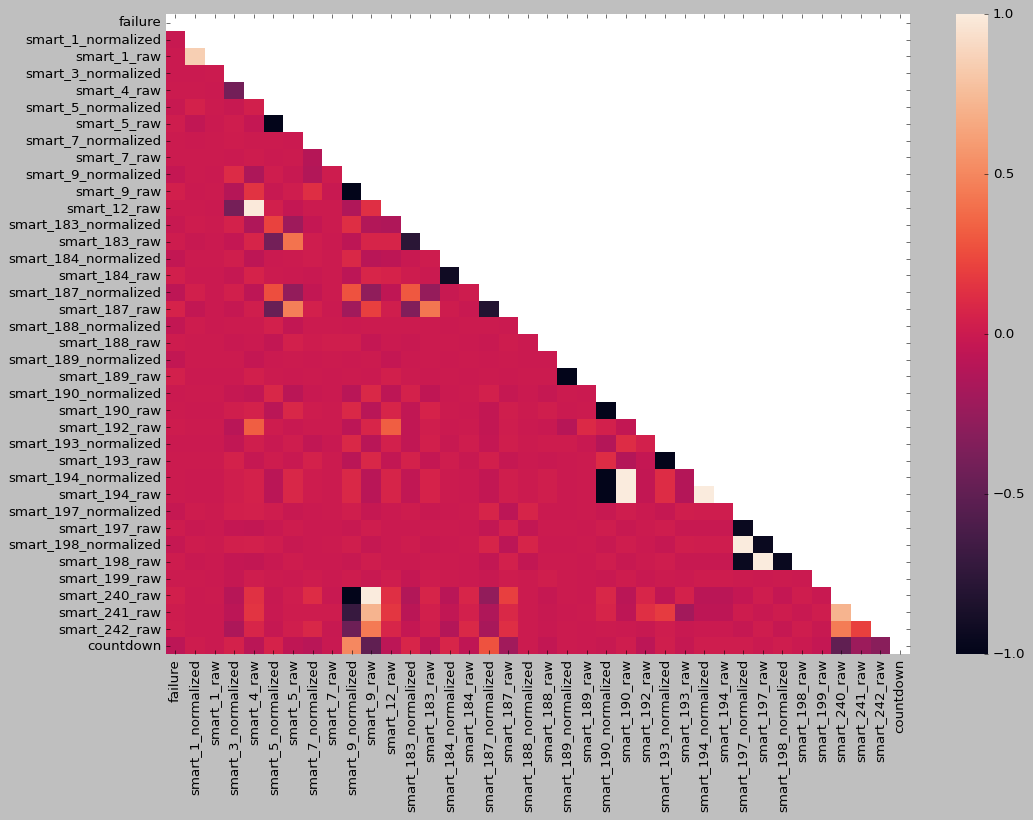

In [43]:
# create correlation matrix over all features
corr_mat = test_model_history.corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(15,10))
g = sns.heatmap(corr_mat, mask=matrix)

In [44]:
# reset the index of the correlation matrix for further analysis (to find the features with the strongest correlation with failure)
corr_mat.reset_index(inplace=True)

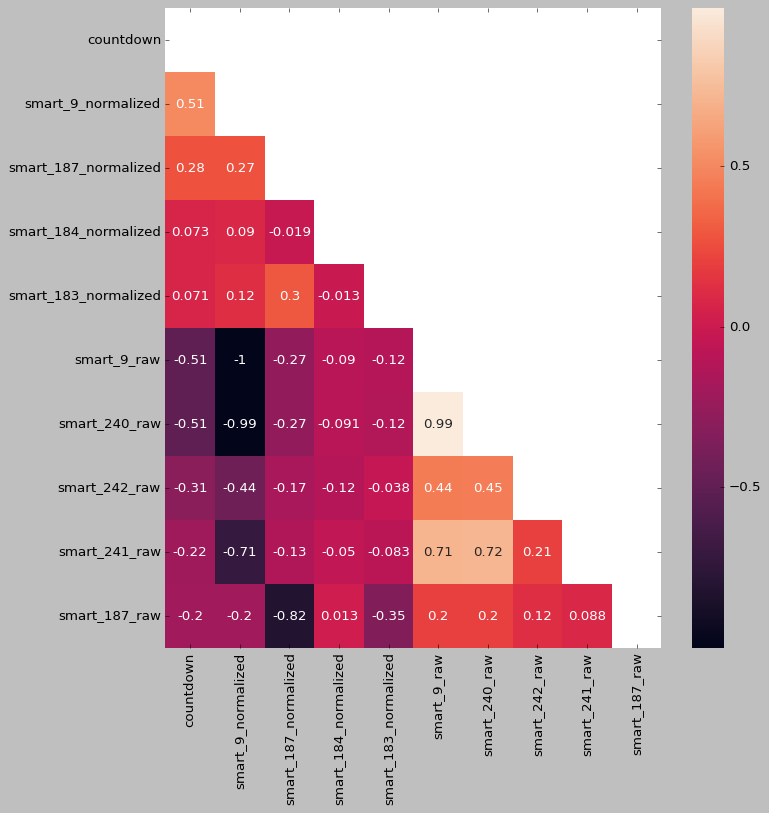

In [45]:
# reduce the correlation features to the most important ones
correlation_features = []

# identify the features with the highest positive correlation
for element in corr_mat.nlargest(5,'countdown')['index']:
    correlation_features.append(element)

# identify the features with the highest negative correlation
for element in corr_mat.nsmallest(5,'countdown')['index']:
    correlation_features.append(element)

# create correlation matrix over the top 10 features
corr_mat = test_model_history[correlation_features].corr()
matrix = np.triu(corr_mat.corr())

# plot correlation matrix
plt.figure(figsize=(10,10))
g = sns.heatmap(corr_mat, mask=matrix, annot=True)

In [46]:
# lineplot = test_model_history[test_model_history['serial_number'] == serial]
columns = []

for col in test_model_history.columns:
    if 'smart' in col:
        columns.append(col)

In [47]:
test_model_history.query('countdown < 0')

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown


In [48]:
test_model_history.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
0,2020-09-15,Z304KBK4,ST4000DM000,0,113.0,53991680.0,92.0,14.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43260.0,5.936166e+10,3.123054e+11,2021-12-16,457.0
1,2020-09-15,Z304JGH0,ST4000DM000,0,111.0,31142392.0,91.0,13.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,42459.0,5.902419e+10,2.553616e+11,2021-01-14,121.0
2,2020-09-15,Z302SYHL,ST4000DM000,0,120.0,238681648.0,92.0,22.0,100.0,0.0,...,99.0,184.0,99.0,184.0,0.0,43769.0,6.132206e+10,2.526737e+11,2021-05-22,249.0
3,2020-09-15,S3010L7K,ST4000DM000,0,118.0,180888736.0,94.0,6.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,46589.0,6.335880e+10,2.237496e+11,2020-12-11,87.0
4,2020-09-15,Z304JM6A,ST4000DM000,0,114.0,59625576.0,92.0,16.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43281.0,5.857410e+10,2.774035e+11,2021-01-24,131.0


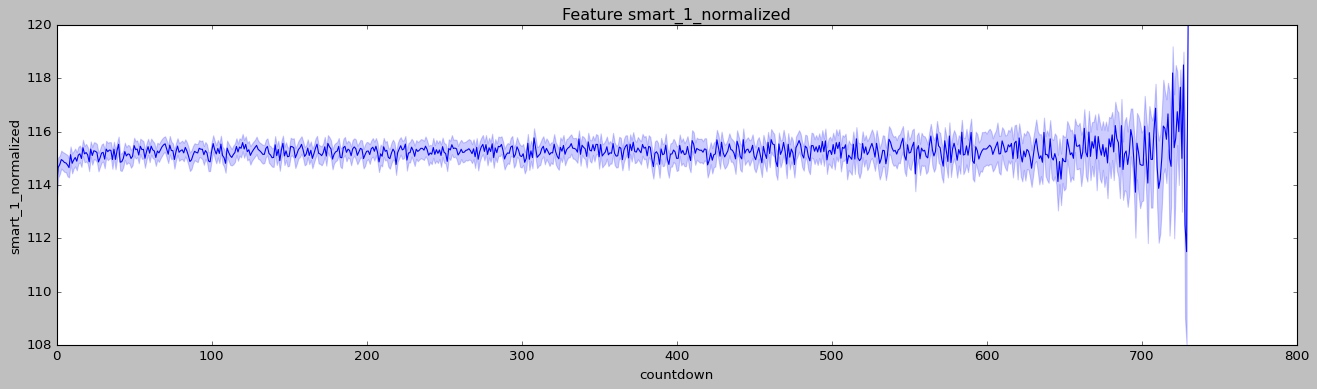

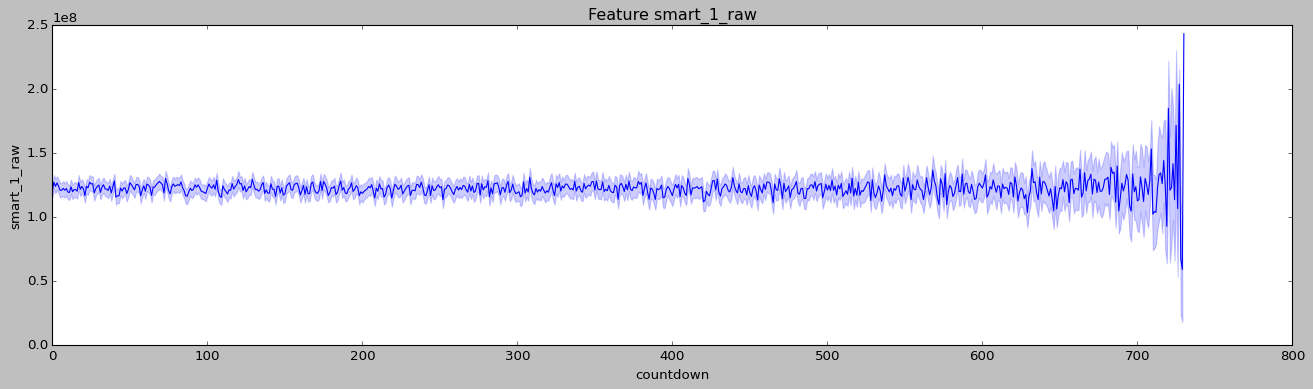

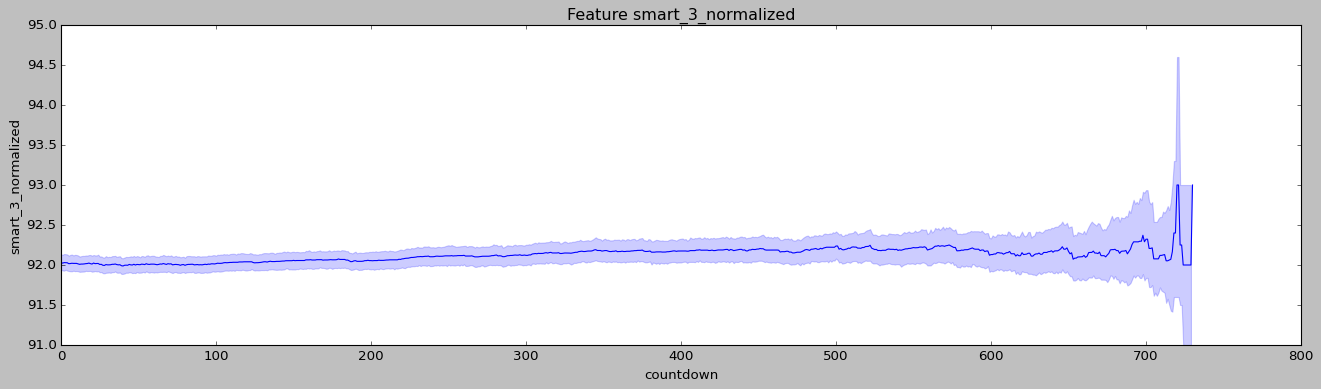

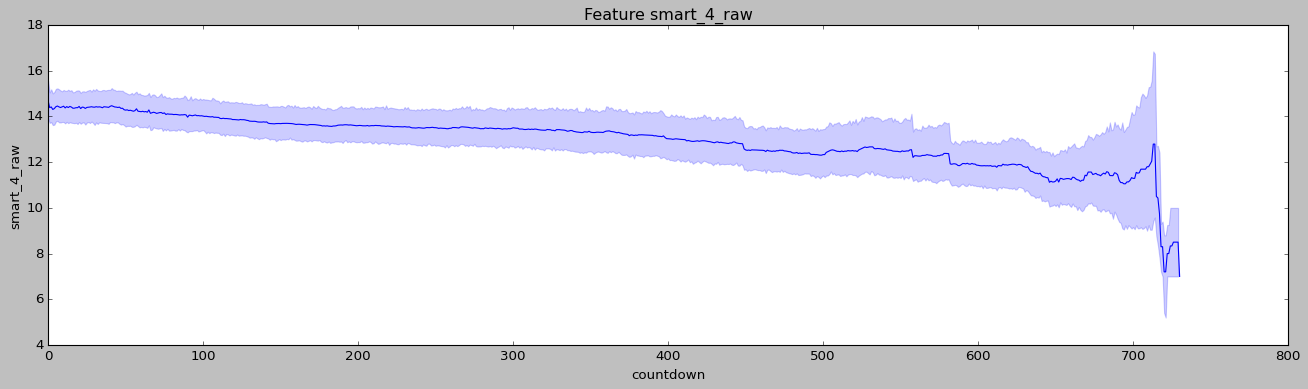

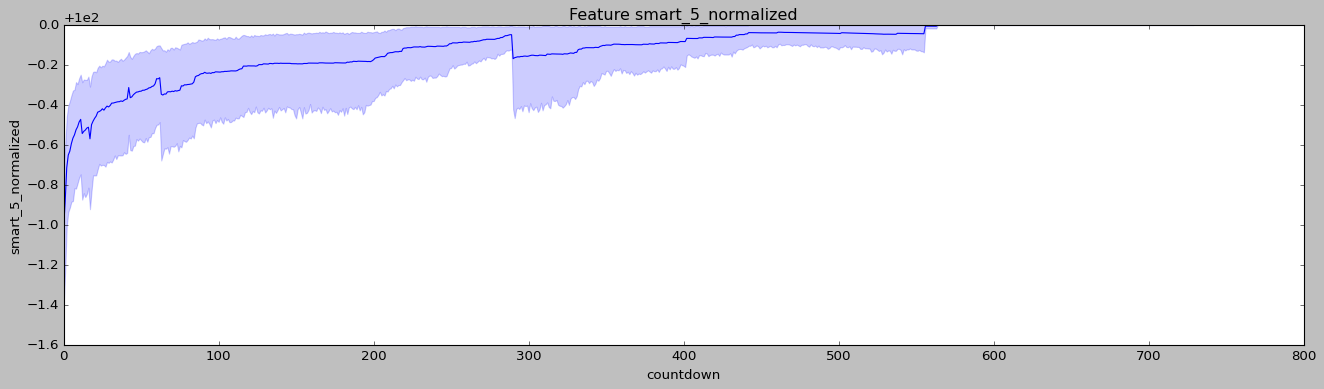

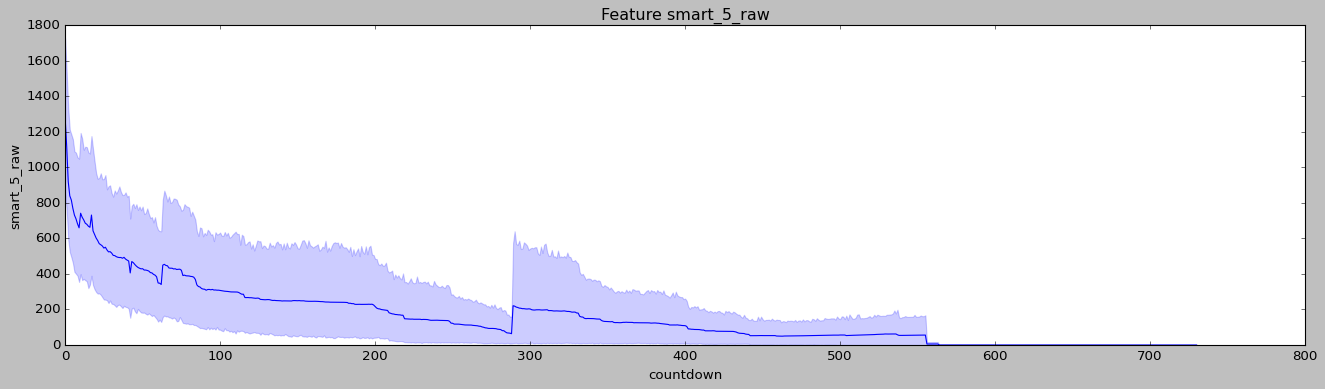

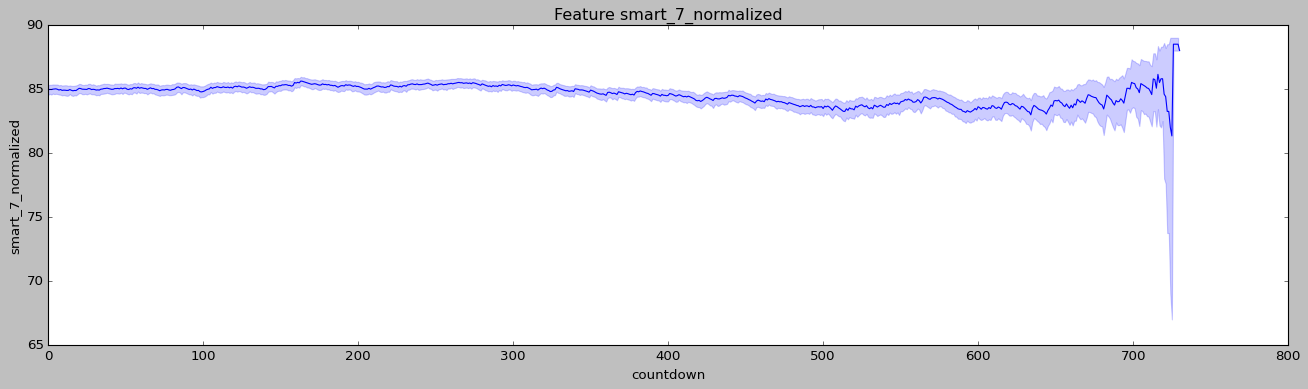

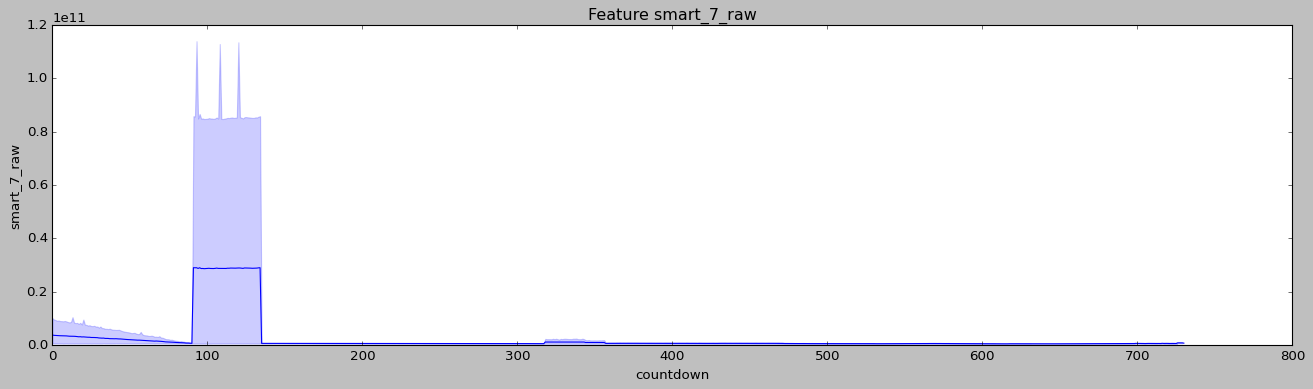

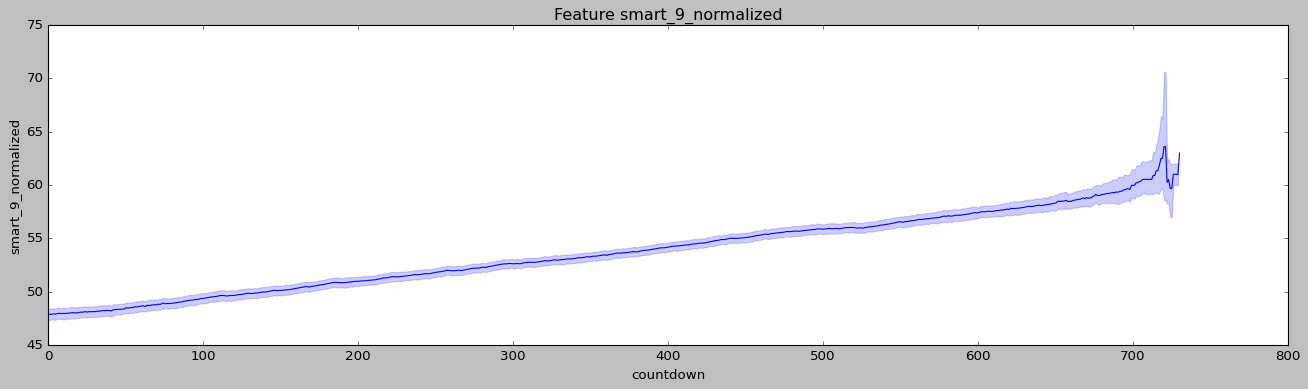

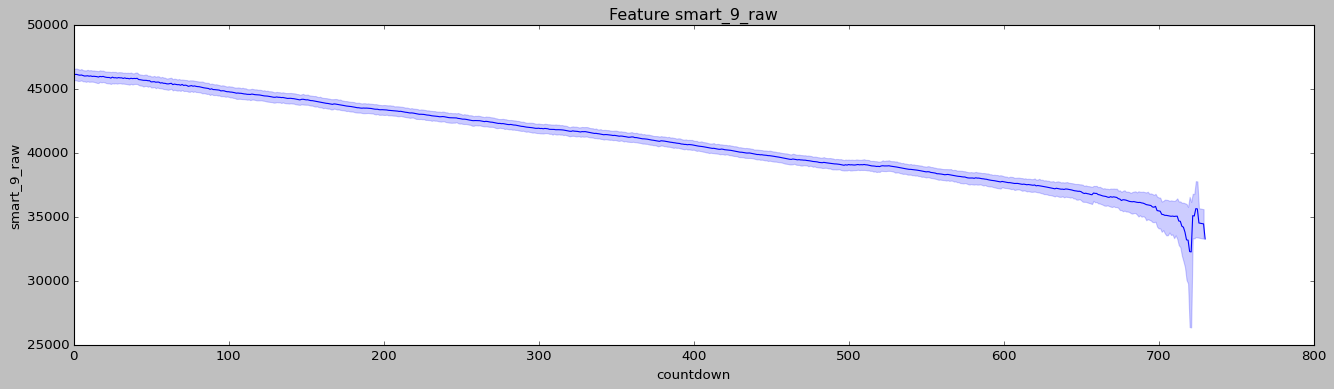

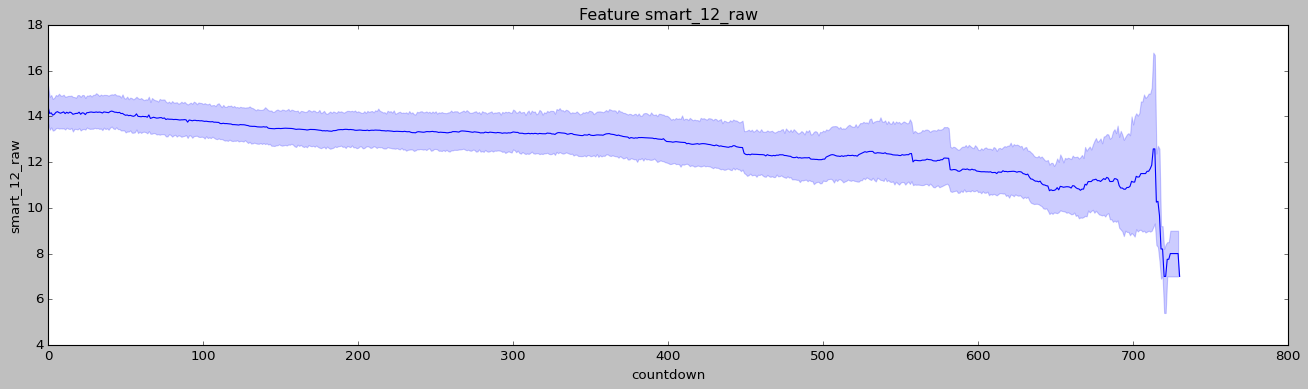

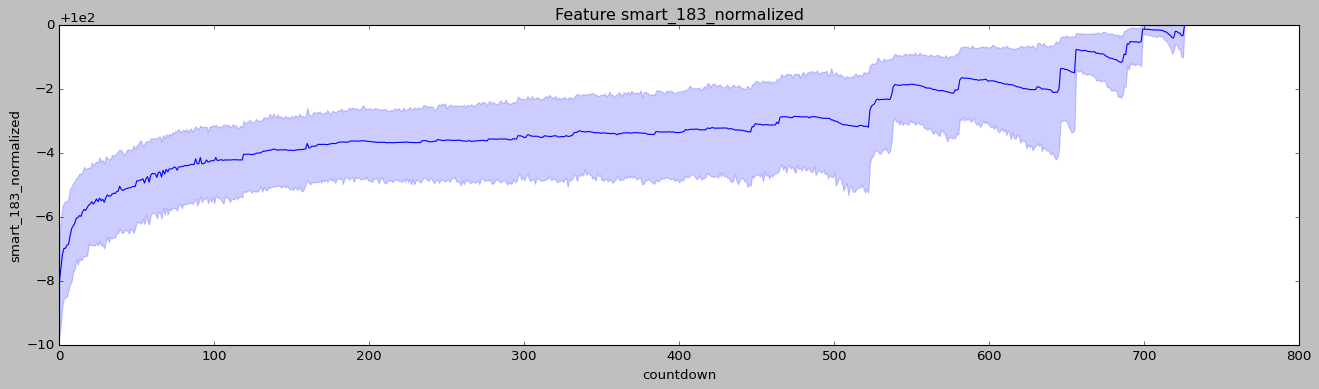

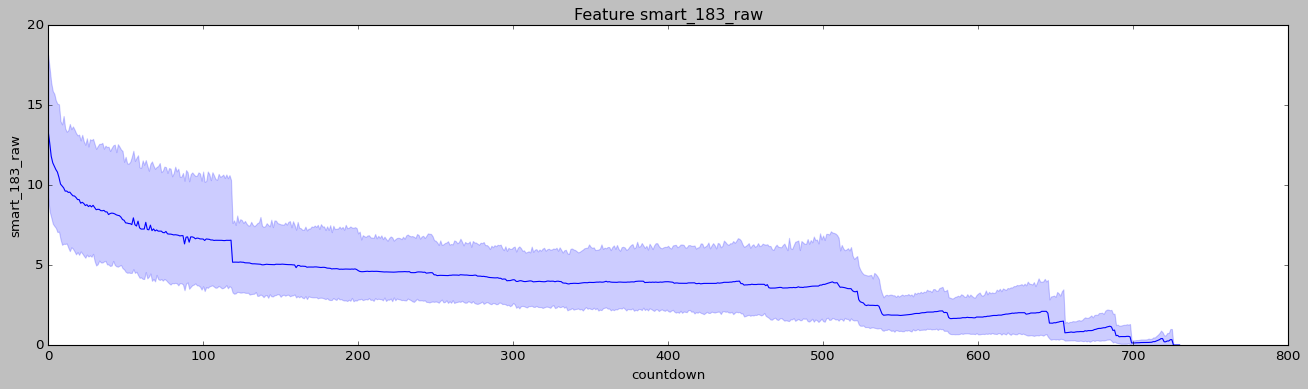

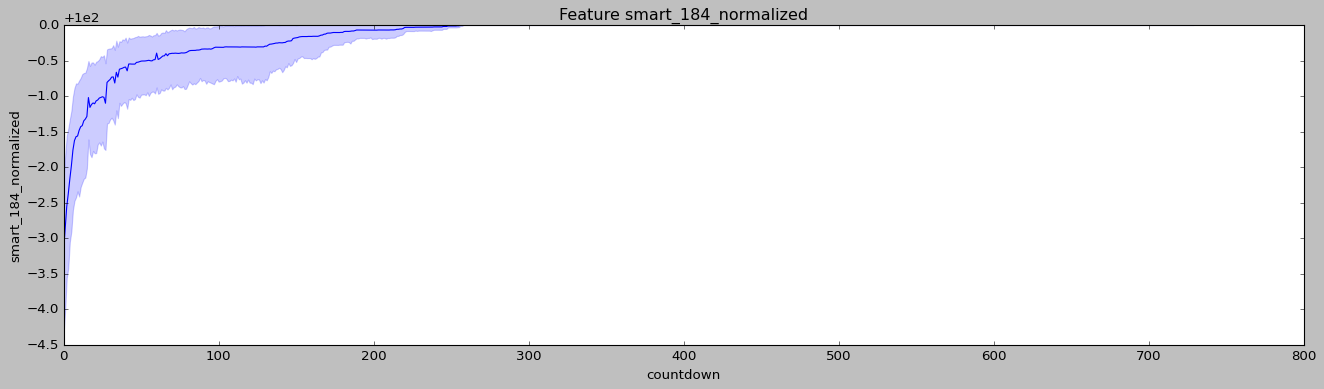

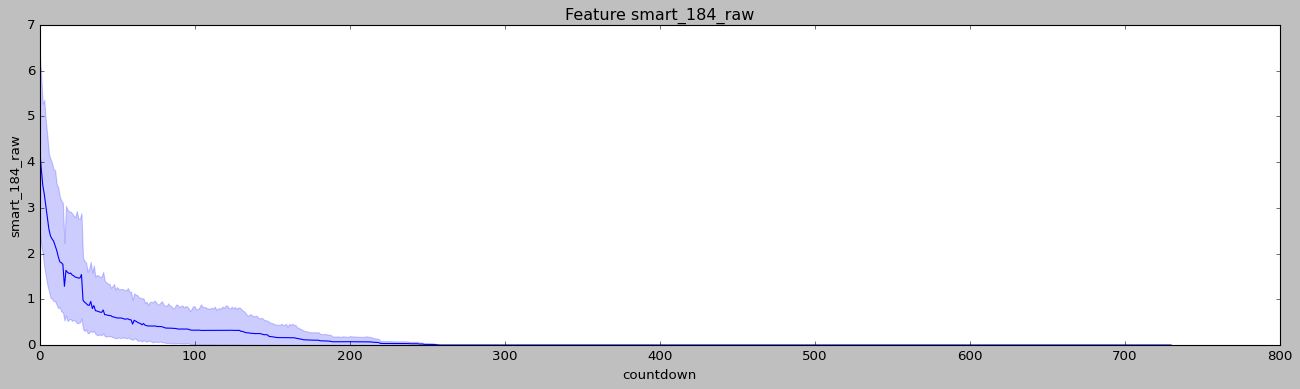

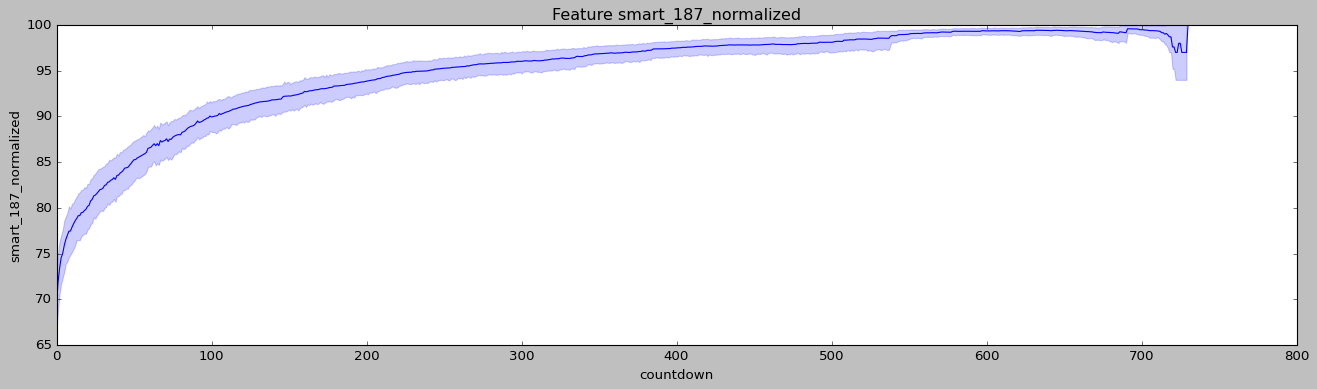

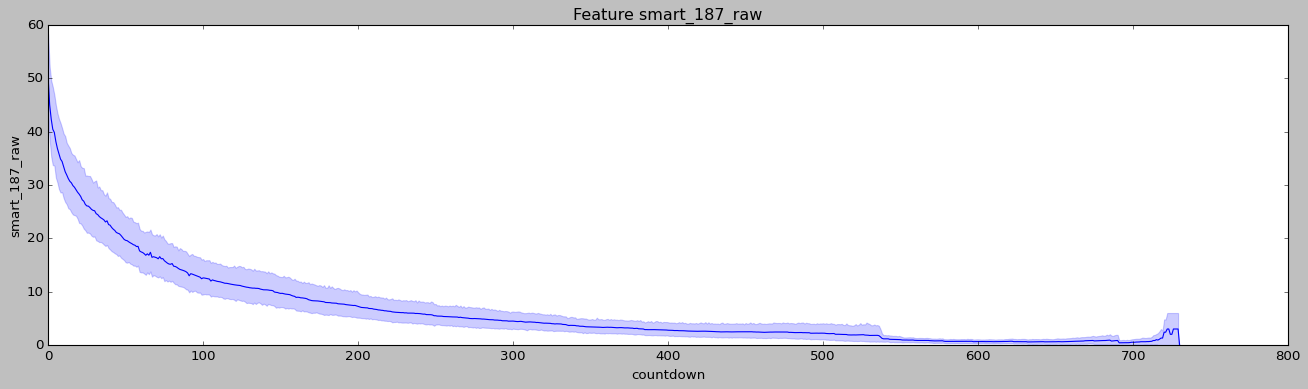

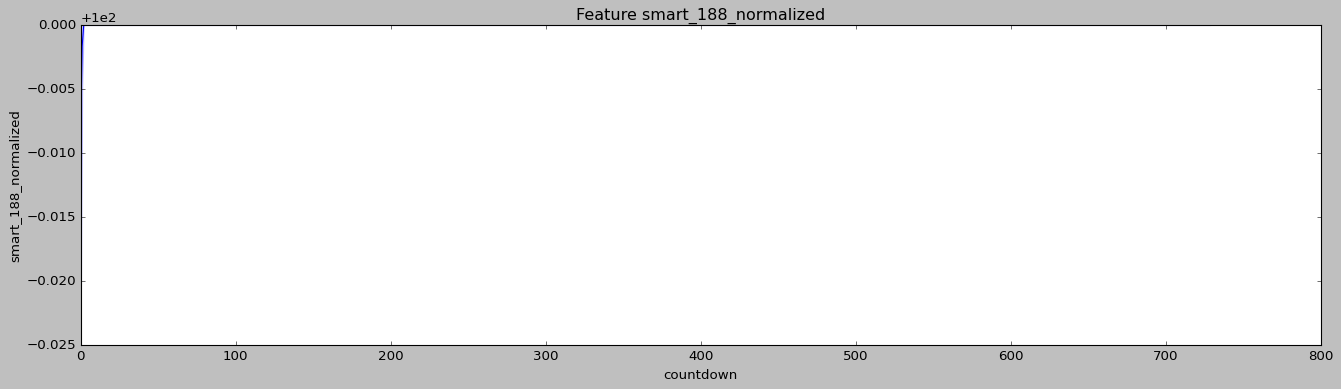

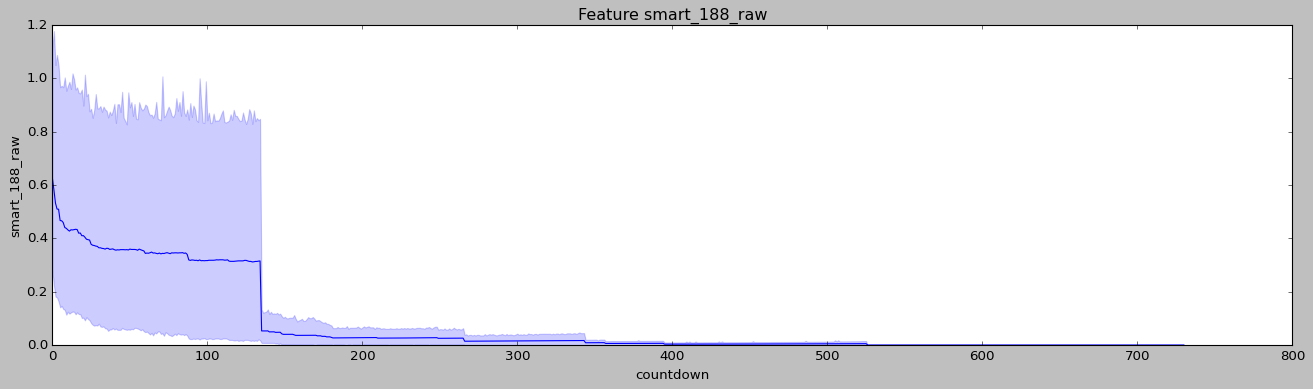

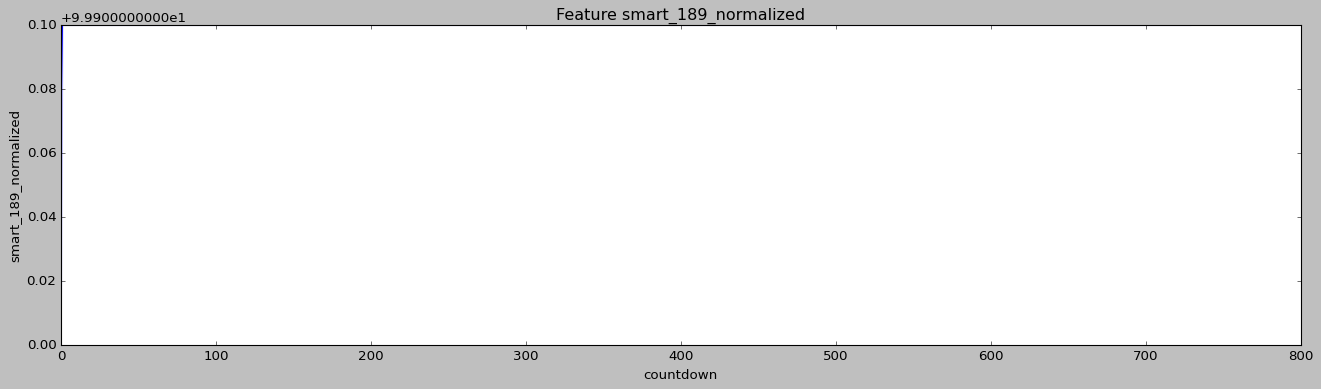

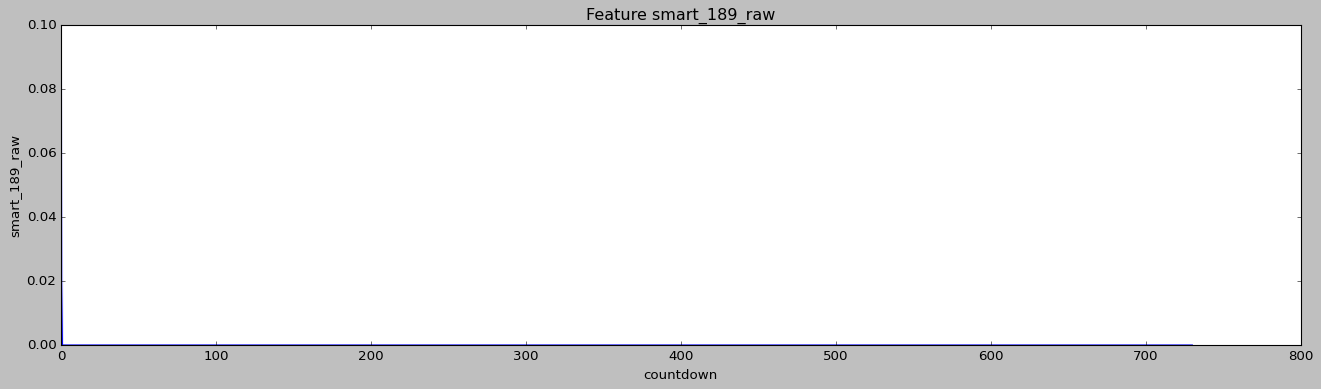

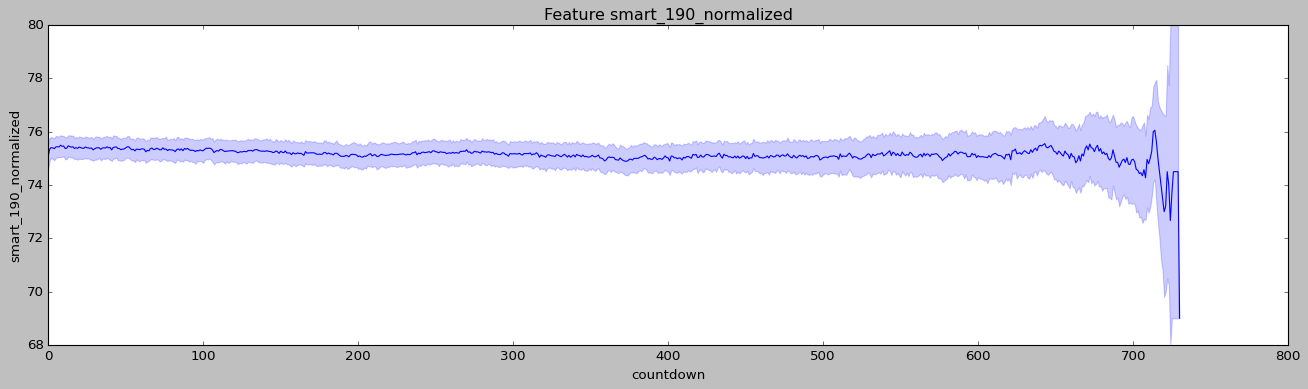

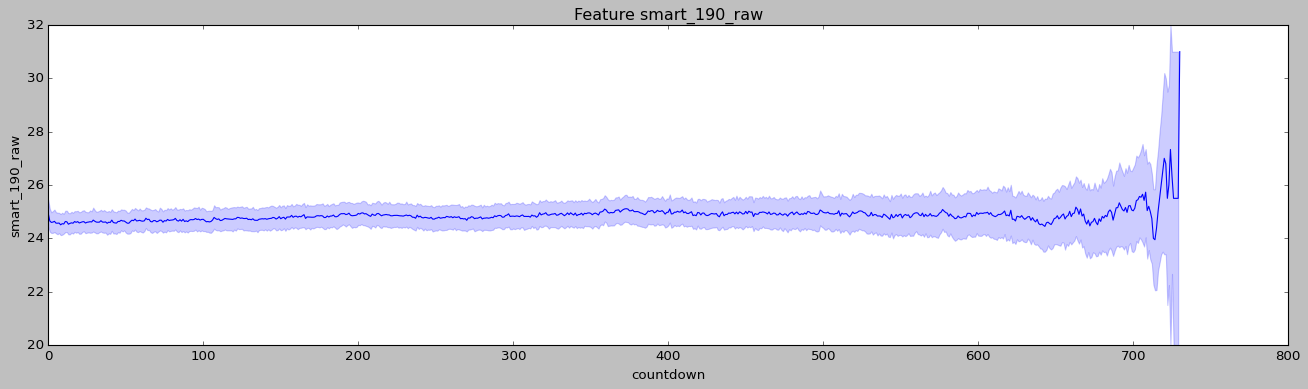

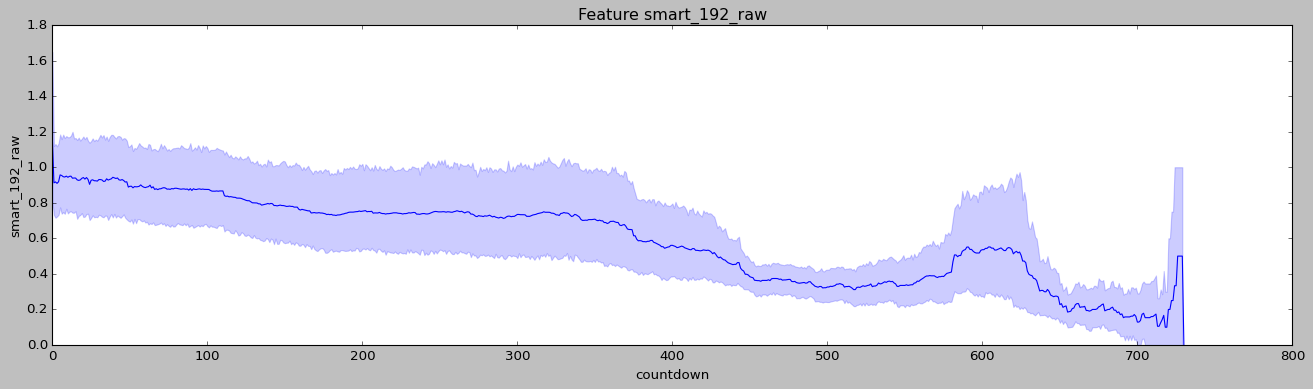

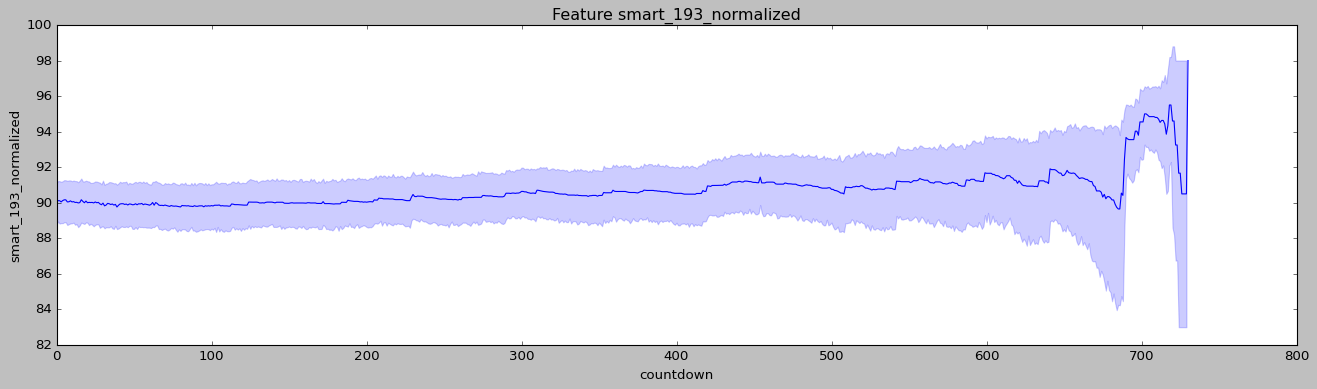

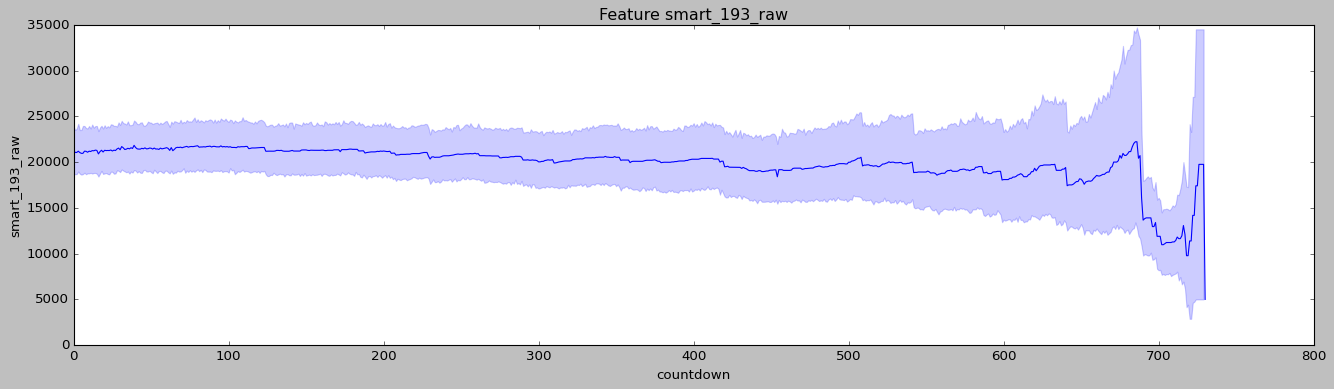

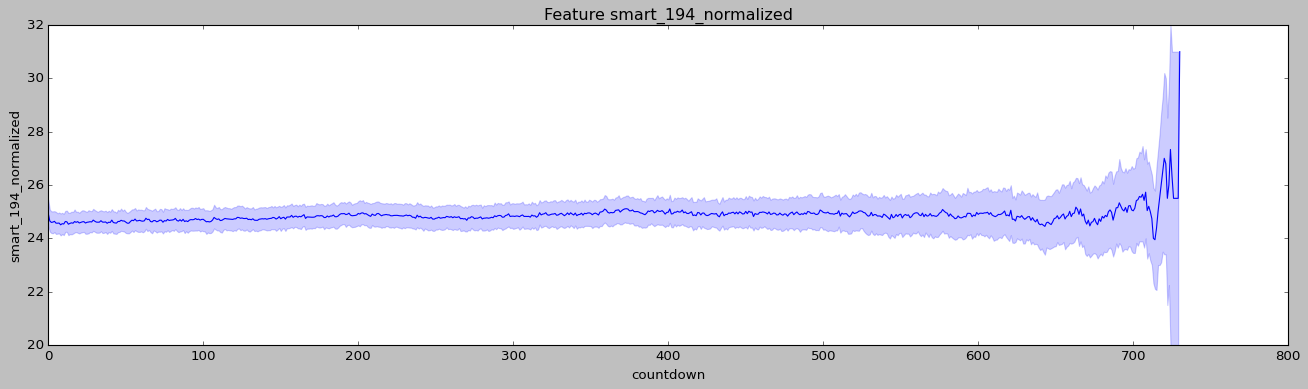

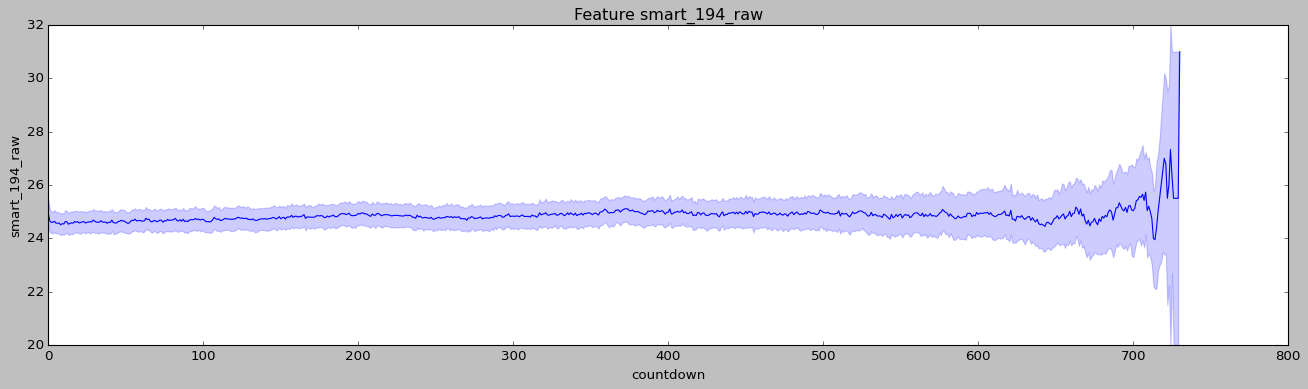

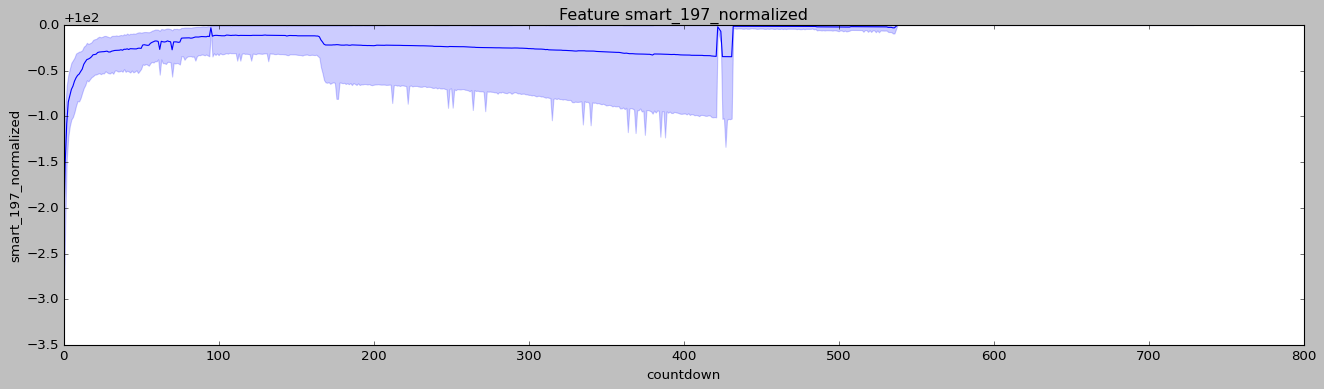

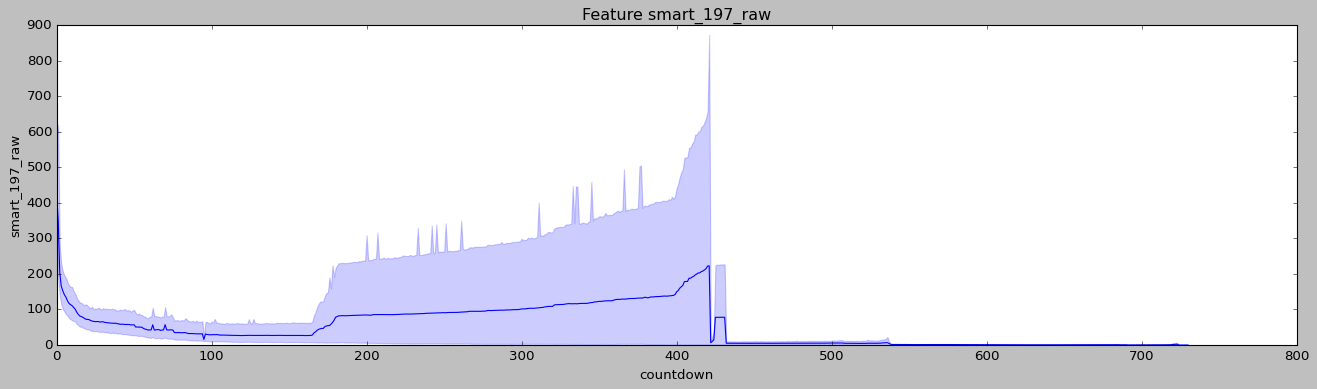

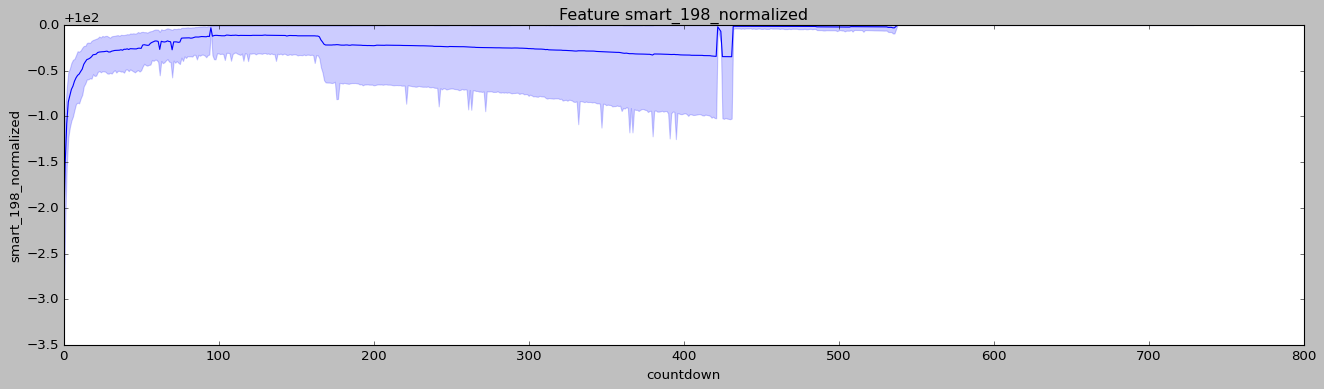

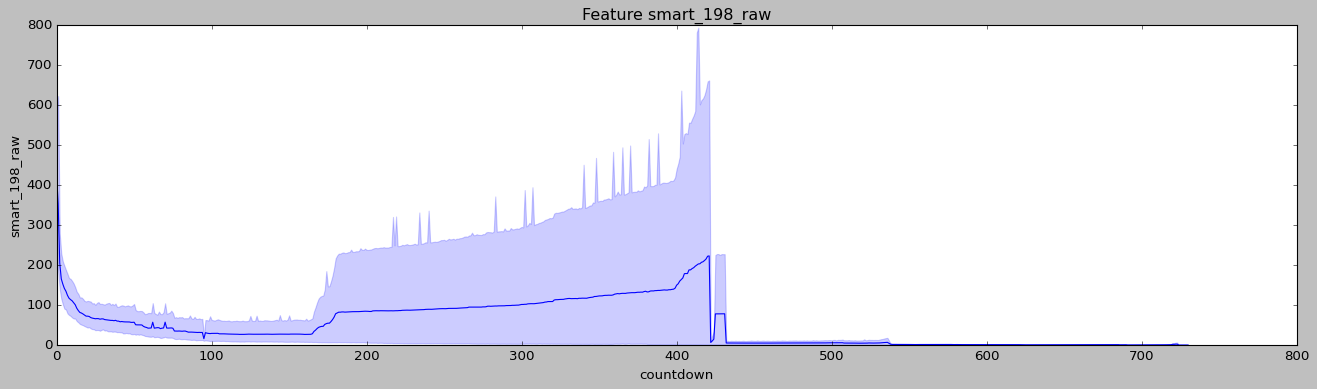

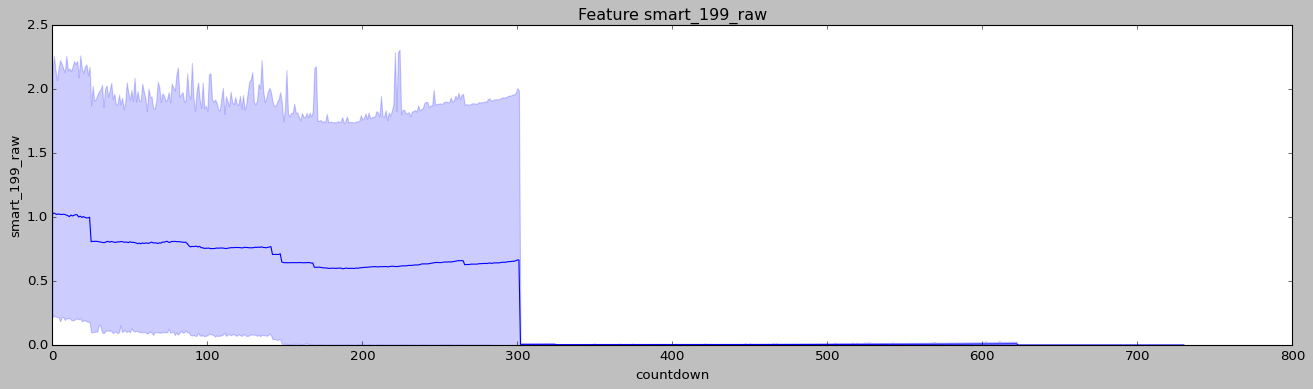

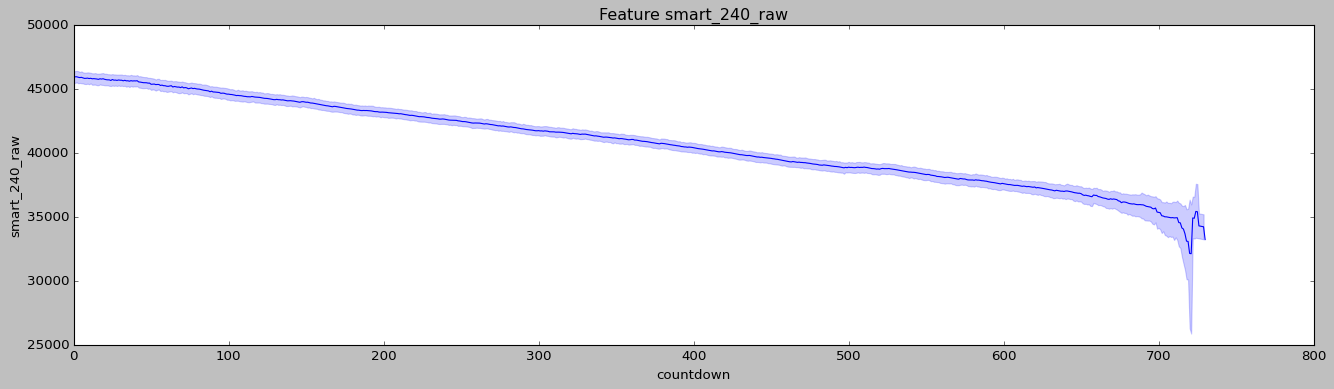

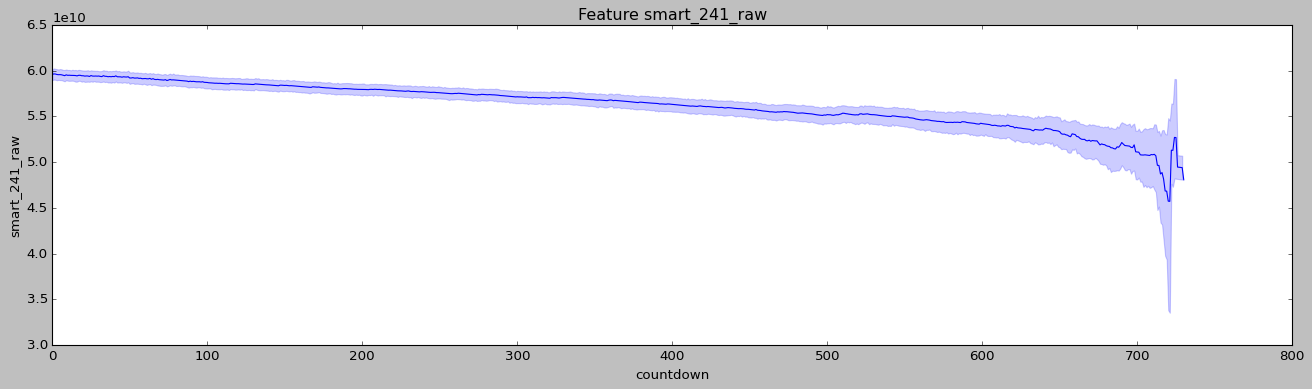

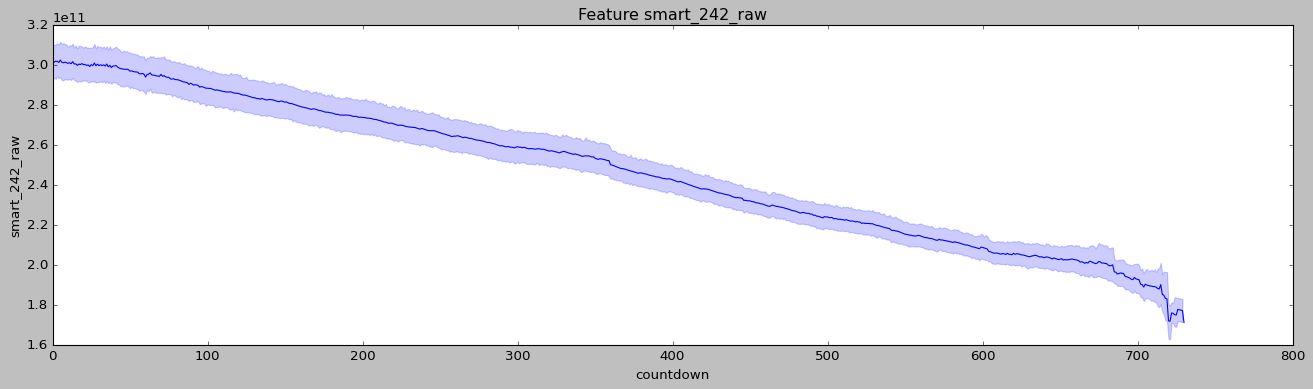

In [49]:
# plt.figure(figsize=(20,5))
# sns.lineplot(data=test_model_history, x='countdown', y=columns[3]);

for col in columns:
    plt.subplots(1, 1, figsize=(20, 5))
    g = sns.lineplot(data=test_model_history, x='countdown', y=col)
    g.set_title(f'Feature {col}')

In [50]:
test_model_history.to_csv('../data/special_purpose/ST4000DM000_processed_relevant.csv', index=False)

## Baseline Model - Regression

The first baseline model for the regression classifier will be built using a dummy regressor which takes the mean as the predicted value.

To achieve this task we import the required libraries, define our X and y features, split the data into training and test set and than instanciate the dummy regressor.
In the next step we fit and predict using the dummy regressor and calculate the mean squared error (mse) for the predicted values.


In [51]:
# Load libraries
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [52]:
test_model_history.head()

,date,serial_number,model,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw,date_failure,countdown
0,2020-09-15,Z304KBK4,ST4000DM000,0,113.0,53991680.0,92.0,14.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43260.0,5.936166e+10,3.123054e+11,2021-12-16,457.0
1,2020-09-15,Z304JGH0,ST4000DM000,0,111.0,31142392.0,91.0,13.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,42459.0,5.902419e+10,2.553616e+11,2021-01-14,121.0
2,2020-09-15,Z302SYHL,ST4000DM000,0,120.0,238681648.0,92.0,22.0,100.0,0.0,...,99.0,184.0,99.0,184.0,0.0,43769.0,6.132206e+10,2.526737e+11,2021-05-22,249.0
3,2020-09-15,S3010L7K,ST4000DM000,0,118.0,180888736.0,94.0,6.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,46589.0,6.335880e+10,2.237496e+11,2020-12-11,87.0
4,2020-09-15,Z304JM6A,ST4000DM000,0,114.0,59625576.0,92.0,16.0,100.0,0.0,...,100.0,0.0,100.0,0.0,0.0,43281.0,5.857410e+10,2.774035e+11,2021-01-24,131.0


In [53]:
# define the X features, droping any feature that is an indication of failure and assigning it to X and saving the target variable into y
X = test_model_history.drop(['failure', 'date', 'date_failure', 'countdown', 'serial_number', 'model'], axis=1)
y = test_model_history.countdown

In [54]:
# splitting the data into train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [55]:
# instantiate the dummy regressor and defining the strategy for our baseline predictions
dummy_mean = DummyRegressor(strategy='mean')

# fit the dummy regressor
dummy_mean.fit(X_train, y_train)

# use the dummy regressor to predict the test set
y_test_pred = dummy_mean.predict(X_test)

In [56]:
# calculate the mean squared error for our test set
mse = mean_squared_error(y_test, y_test_pred)
print(f'The mean squared error for the baseline model is: {round(mse, 3)}')

The mean squared error for the baseline model is: 30728.093
